# First task
- Build a dataset of spin glass graphs with a fixed number of nodes (10) and study the learning of energy by a GNN with a different number of connections.

### Table of contents:
1. [Utility functions](#functions)
2. [Definition of the GNN model](#gnn_definition)
3. [Training and validation](#training)
4. [Magnetization Learning (for task 2)](#magnetization)


In [13]:
# import the libraries
import torch
from torch_geometric.data import Data
from torch_geometric.utils import to_networkx, from_networkx
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.offsetbox import AnchoredText

import torch.nn.functional as F
from torch_geometric.profile import get_model_size

from torch.nn import Linear
from torch_geometric.nn import global_max_pool, GraphConv
from torch_geometric.loader import DataLoader

import os 


In [14]:
# set standard dimensions for the plots
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 14
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['legend.fontsize'] = 14


# Utility functions <a class="anchor" id="functions"></a>
In the following cell there are functions used to build the graph and for the first task. 

In [15]:
# The following functions are used to create the dataset for the SpinGlass model


def initialize_graph(L, periodic=True, n_dimensions=2):
    """
    Initialize a graph with L nodes
    """
    G = nx.Graph()
    for i in range(L):
        G.add_node(i, spin = np.random.choice([-1, 1]))
    
    for i in range(L):
        if periodic:
            for j in range(i+1, i+n_dimensions+1):
                G.add_edge(i, j % L, weight = np.random.rand()*2 -1 )
        else:
            for j in range(i+1, i+n_dimensions+1):
                if j < L:
                    G.add_edge(i, j, weight = np.random.rand()*2 -1 )
    return G
     

def plot_graph(G, pos=None):
    """
    Plot the graph with nodes colored according to their spin.
    """
    if pos is None:
        pos = nx.circular_layout(G)
    colors = ['blue' if G.nodes[i]["spin"] == 1 else 'red' for i in range(len(G.nodes) )]
    fig = plt.figure()
    nx.draw(G, pos = pos, node_color=colors, with_labels=True)
    plt.show(fig)    
    return fig
    

def calculate_energy(G, h=0 ):
    """
    Calculate the energy of the graph
    """
    E = 0
    E_h = 0
    for i, j in G.edges:
        E += G[i][j]["weight"] * G.nodes[i]["spin"] * G.nodes[j]["spin"]

    if h != 0:  # exclude the case of h = 0 to avoid floating point errors
        E_h = h * np.sum([G.nodes[i]["spin"] for i in G.nodes]) 

    return -E/2 - E_h  # divide by 2 to avoid double counting

def calculate_magnetization(G):
    """
    Calculate the magnetization of the graph
    """
    return np.sum([G.nodes[i]["spin"] for i in G.nodes])

# create a dataset with the energy as label
def create_dataset(n_nodes=10, h=0, periodic= True, n_dimensions=1, n_samples=1000, return_MLP=False, save = False, path = None, mode = "energy"):
    dataset = []
    graphs = []
    MLP_list= []

    if mode == "energy":
        bool_energy = True
    elif mode == "magnetization":
        bool_energy = False
    else:
        raise ValueError("mode must be either 'energy' or 'magnetization'")

    for i in range(n_samples):
        G = initialize_graph(n_nodes, periodic=periodic, n_dimensions=n_dimensions)
        X = torch.tensor([G.nodes[i]["spin"] for i in G.nodes]).float().view(-1, 1)
        graphs.append(G)

        if bool_energy:
            Y = torch.tensor([calculate_energy(G, h=h)]).float()
        else:
            Y = torch.tensor([calculate_magnetization(G)]).float()

        dataset.append(
            Data(x = X, 
                edge_index = torch.tensor(np.array(G.edges).T, dtype=torch.long),
                edge_weight = torch.tensor([G[i][j]["weight"] for i, j in G.edges], dtype=torch.float),
                y = Y ) )  
                

        if save:
            if path is None:
                path = os.getcwd()
            if not os.path.exists(path):
                os.makedirs(path)
            torch.save(dataset, os.path.join(path, f"dataset_{n_nodes}_{h}_{periodic}_{n_dimensions}_{n_samples}.pt"))
            torch.save(graphs, os.path.join(path, f"graphs_{n_nodes}_{h}_{periodic}_{n_dimensions}_{n_samples}.pt"))

    if return_MLP:

        # extract the adjacency matrix
        A = nx.adjacency_matrix(G).todense()
        # concatenate the adjacency matrix to the node features to use it for the MLP in the other task
        M = torch.cat([X, torch.tensor(A).float()], dim=1)
        MLP_list.append(M)

        if save:
            torch.save(MLP_list, os.path.join(path, f"MLP_list_{n_nodes}_{h}_{periodic}_{n_dimensions}_{n_samples}.pt"))
        return dataset, graphs, MLP_list
    else:
        return dataset, graphs

# Definition of the GNN model <a class="anchor" id="gnn_definition"></a>


In [16]:
# GNN model

class GNN(torch.nn.Module):
    """
    class for the GNN model

    inputs parameters:
    - hidden_channels_1: number of hidden channels for the first layer
    - hidden_channels_2: number of hidden channels for the second layer
    - hidden_channels_3: number of hidden channels for the third layer
    - hidden_channels_4: number of hidden channels for the fourth layer
    - hidden_linear: number of hidden channels for the linear layer
    - lr: learning rate
    - weight_decay: weight decay
    - dropout: dropout rate
    - num_node_features: number of node features
    - num_classes: number of classes

    output:
    - out: the output of the model
    """
    def __init__(self,hidden_channels_1=16, hidden_channels_2=16, hidden_channels_3=16,hidden_channels_4 = 16, hidden_linear=16,
                 lr = 1e-5, weight_decay=1e-3, dropout=0.5, num_node_features=1, num_classes=1):
        super(GNN, self).__init__()
        self.conv1 = GraphConv(num_node_features,hidden_channels_1)
        self.conv2 = GraphConv(hidden_channels_1, hidden_channels_2)
        self.conv3 = GraphConv(hidden_channels_2, hidden_channels_3)
        self.conv4 = GraphConv(hidden_channels_3, hidden_channels_4)

        self.pool = global_max_pool

        self.linear1 = Linear(hidden_channels_4, hidden_linear)
        self.linear2 = Linear(hidden_linear, num_classes)

        

        self.dropout = torch.nn.Dropout(dropout)

        # we should consider also batch normalization in case of overfitting



        # Optimizer:
        self.optimizer = torch.optim.Adam(self.parameters(), lr=lr, weight_decay=weight_decay)

        # Loss function:
        self.criterion = torch.nn.MSELoss()

        
    
    def forward(self, data):
        x, edge_index, edge_weight = data.x, data.edge_index, data.edge_weight
        x = F.leaky_relu(self.conv1(x, edge_index, edge_weight))
        x = F.leaky_relu(self.conv2(x, edge_index, edge_weight))
        x = F.leaky_relu(self.conv3(x, edge_index, edge_weight))
        x = F.leaky_relu(self.conv4(x, edge_index, edge_weight))

        x = self.pool(x, data.batch) # [n_nodes*n_graph_of_the_batch, n_features] -> [n_graph_of_the_batch, n_features]

        #x = torch.flatten(x) # not needed since we are using global_max_pool
        #print(x.shape)
        x = self.dropout(x)
        x = F.leaky_relu(self.linear1(x))
        out = self.linear2(x)

        return out
    

    
    def train_step(self, data):
        # Reset gradients
        self.optimizer.zero_grad()
        # Passing the node features and the connection info
        prediction = self.forward(data)
        # reshape the prediction to match the shape of the target
        prediction = prediction.view(data.y.shape)
        # Calculating the loss and gradients
        loss = self.criterion(prediction, data.y)
        #print("prediction:",prediction.shape)
        #print("data.y:",data.y.shape)
        loss.backward()
        # Update using the gradients
        self.optimizer.step()
        
        return loss.item()
    

In [17]:
def plot_loss( train_losses, test_losses):
    fig = plt.figure()
    epoch = range(1, len(train_losses)+1)
    plt.plot(epoch, train_losses, label='Training Loss')
    plt.plot(epoch, test_losses, label='Test Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Losses')
    plt.legend()
    plt.grid(True)
    plt.show()
    return fig


def train_model(model, train_loader, test_loader, num_epochs, patience = 5, model_name='best_model', verbose = True, device= None, ax_name = "energy"):

    if device is None:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # parameters for patience
    best_loss = np.inf
    patience_counter = 0


    epochs = range(1, num_epochs+1)
    train_losses, test_losses = [], []
    
    print('Training ...')

    for epoch in epochs:
        loss_per_epoch = []
        test_loss_per_epoch = []

        for i, mini_batch in enumerate(train_loader):
            mini_batch.to(device)
            train_loss = model.train_step(mini_batch)
            loss_per_epoch.append(train_loss)

        train_losses.append(sum(loss_per_epoch)/len(loss_per_epoch))


        with torch.no_grad():
            """Evaluate the model on test set"""
            for i, mini_batch in enumerate(test_loader):
                mini_batch.to(device)
                prediction = model.forward(mini_batch)
                prediction.to('cpu')
                test_loss = model.criterion(prediction, mini_batch.y).item()
                test_loss_per_epoch.append(test_loss)
            test_losses.append(sum(test_loss_per_epoch)/len(test_loss_per_epoch))
            
            if test_losses[-1] < best_loss:
                best_loss = test_losses[-1]
                torch.save(model.state_dict(), model_name + '/model.pth')
                patience_counter = 0
            else:
                patience_counter += 1
                if patience_counter == patience:
                    print(f"Early stopping at epoch {epoch}")
                    break
        if verbose:
            print(f"Ep {epoch} \t| Loss {round(train_losses[-1], 5)} \t| Test Loss {round(test_losses[-1], 5)}")


    return  train_losses, test_losses

In [18]:
# set the model name based on the values
def set_model_name(n_nodes, n_dimensions, h, periodic,n_samples, hidden_channels_1,
                    hidden_channels_2, hidden_channels_3, hidden_channels_4, hidden_linear,
                    lr, weight_decay, dropout, epochs):
    return f"model_{n_nodes}_{n_dimensions}_{h}_{periodic}_{n_samples}_{hidden_channels_1}_{hidden_channels_2}_{hidden_channels_3}_{hidden_channels_4}_{hidden_linear}_{lr}_{weight_decay}_{dropout}_{epochs}"


# translate the model name into values
def print_values_from_model_name(model_name, print_values=True, return_dict = False): 
    values = model_name.split('_')
    # create a dictionary to store the values 
    dict = {"n_nodes": values[1], "n_dimensions": values[2], "h": values[3], "periodic": values[4], "n_samples": values[5],
            "hidden_channels_1": values[6], "hidden_channels_2": values[7], "hidden_channels_3": values[8], "hidden_channels_4": values[9], "hidden_linear": values[10],
            "lr": values[11], "weight_decay": values[12], "dropout": values[13], "epochs": values[14]}
    if print_values:
        for key, value in dict.items():
            print(f"{key}: {value}")
    if return_dict:
        return dict
    
    

def test_trained_model(model_name, test_loader, device = None, ax_name = "energy"):

    if device is None:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        
    values = print_values_from_model_name(model_name, print_values=False, return_dict=True)

    trained_model = GNN(hidden_channels_1= int(values["hidden_channels_1"]),
                hidden_channels_2= int(values["hidden_channels_2"]),
                hidden_channels_3= int(values["hidden_channels_3"]),
                hidden_channels_4= int(values["hidden_channels_4"]),
                hidden_linear= int(values["hidden_linear"]),
                lr= float(values["lr"]), weight_decay= float(values["weight_decay"]), dropout= float(values["dropout"]))
    
    trained_model.load_state_dict(torch.load(model_name + '/model.pth'))
    trained_model.to(device)

    fig = plt.figure()
    with torch.no_grad():
        predictions = []
        true_values = []
        for i, mini_batch in enumerate(test_loader):
            mini_batch.to(device)
            prediction = trained_model.forward(mini_batch)
            predictions.append(prediction.item())
            true_values.append(mini_batch.y.item())
        
        # save the mean squared error
        mse = np.mean((np.array(predictions) - np.array(true_values))**2)
       
        plt.scatter(true_values, predictions)
        plt.plot(true_values, true_values, color='red')
        plt.xlabel('True ' + ax_name)
        plt.ylabel('Predicted' + ax_name)
        plt.title('Predicted vs True ' + ax_name)
    
        at = AnchoredText(f"MSE: {np.round(mse,2)}", frameon=True, loc='upper left')
        plt.gca().add_artist(at)

        # plot a box similar to the legend to show the MSE
        plt.grid(True)
        plt.show()
    
    

    return fig, mse


In [19]:
# set the device and a random seed
torch.manual_seed(1022000)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') 
print('Device: ', device)

# set the palette
palette = sns.color_palette("coolwarm", as_cmap=True)

Device:  cuda


# Training and validation <a class="anchor" id="training"></a>

In [20]:
# set standard parameters for the model

# parameters for the dataset
n_nodes = 10
h = 0
n_samples = 5000

# parameters for the model
num_epochs = 30
batch_size = 1
lr = 5e-4
weight_decay = 1e-4
dropout = 0.1
patience = 15

# parameters for the layers
hidden_channels_1 = 16
hidden_channels_2 = 32
hidden_channels_3 = 32
hidden_channels_4 = 64
hidden_linear = 32

In [21]:
# create the model
starting_model = GNN(hidden_channels_1=hidden_channels_1, hidden_channels_2=hidden_channels_2, hidden_channels_3=hidden_channels_3,
            hidden_channels_4=hidden_channels_4, hidden_linear=hidden_linear, lr=lr, weight_decay=weight_decay, dropout=dropout)

# Model size and number of parameters of the model:
print(44 * '-')
print("Model:")
print("Model size (bytes):\t\t  ", get_model_size(starting_model))
print("Number of parameters:\t\t  ", sum(p.numel() for p in starting_model.parameters()))
print(44 * '-')


--------------------------------------------
Model:
Model size (bytes):		   43862
Number of parameters:		   9457
--------------------------------------------


In [22]:
# prepare lists to store the results
list_dimensions = [1,2,3,4,5]
list_periodic = [False, True]
list_datasets = []
list_graphs = []
list_n_connections = []
list_model_names = []
list_train_losses = []
list_test_losses = []
list_fig_losses = []
list_fig_tests = []
list_mse = []

In [23]:
# create and save the datasets
create = True
save = True


# MLP_list is really time consuming,
# it's more clever to save only the datasets and build the graphs and MLP_list again if needed (task 2)


try:
    os.mkdir("datasets")
except:
    pass

if create:
    for n_dimensions in list_dimensions:
        for periodic in list_periodic:
            print(f"creating datasets with: n_dimensions: {n_dimensions}, periodic: {periodic}")
            
            dataset, graphs = create_dataset(n_nodes=n_nodes, h=h, periodic=periodic, n_dimensions=n_dimensions, n_samples=n_samples, save=False)
            list_datasets.append(dataset)
            list_graphs.append(graphs)

            if save:
                torch.save(dataset, f"datasets/dataset_{n_nodes}_{h}_{periodic}_{n_dimensions}_{n_samples}.pt")
                torch.save(graphs, f"datasets/graphs_{n_nodes}_{h}_{periodic}_{n_dimensions}_{n_samples}.pt")
else:
    print("loading datasets")
    for n_dimensions in list_dimensions:
        for periodic in list_periodic:
            dataset = torch.load(f"datasets/dataset_{n_nodes}_{h}_{periodic}_{n_dimensions}_{n_samples}.pt")
            graphs = torch.load(f"datasets/graphs_{n_nodes}_{h}_{periodic}_{n_dimensions}_{n_samples}.pt")
            list_datasets.append(dataset)
            list_graphs.append(graphs)
print("Done!")

creating datasets with: n_dimensions: 1, periodic: False
creating datasets with: n_dimensions: 1, periodic: True
creating datasets with: n_dimensions: 2, periodic: False
creating datasets with: n_dimensions: 2, periodic: True
creating datasets with: n_dimensions: 3, periodic: False
creating datasets with: n_dimensions: 3, periodic: True
creating datasets with: n_dimensions: 4, periodic: False
creating datasets with: n_dimensions: 4, periodic: True
creating datasets with: n_dimensions: 5, periodic: False
creating datasets with: n_dimensions: 5, periodic: True
Done!


n_dimensions: 1, periodic: False, number of connections: 9


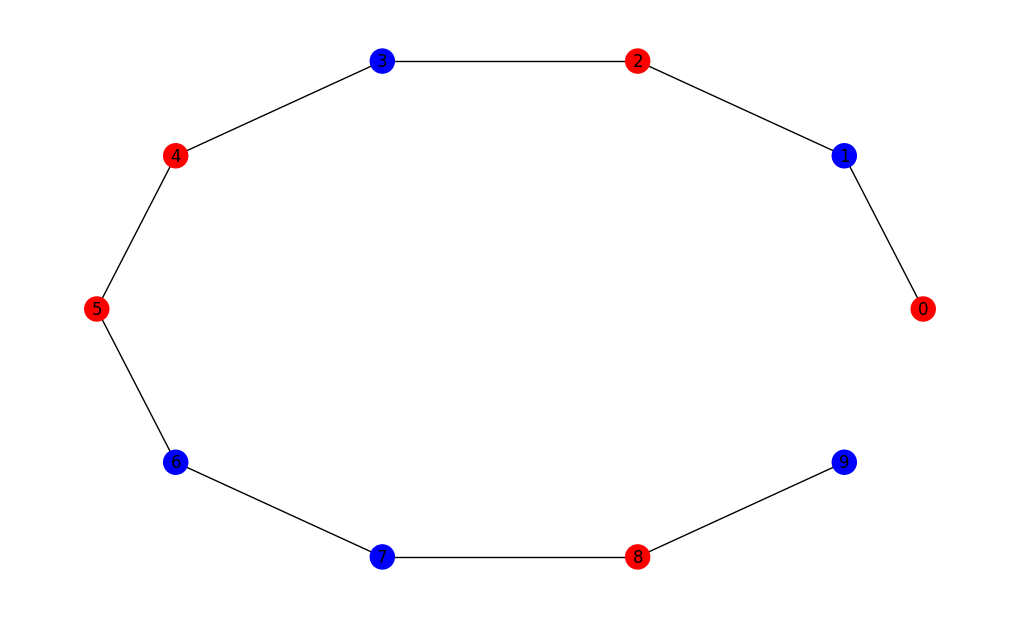

Training ...
Ep 1 	| Loss 0.20608 	| Test Loss 0.10845
Ep 2 	| Loss 0.10518 	| Test Loss 0.09782
Ep 3 	| Loss 0.08982 	| Test Loss 0.08454
Ep 4 	| Loss 0.08107 	| Test Loss 0.08786
Ep 5 	| Loss 0.07598 	| Test Loss 0.07799
Ep 6 	| Loss 0.07221 	| Test Loss 0.08822
Ep 7 	| Loss 0.06704 	| Test Loss 0.07728
Ep 8 	| Loss 0.06449 	| Test Loss 0.07
Ep 9 	| Loss 0.06159 	| Test Loss 0.06874
Ep 10 	| Loss 0.06092 	| Test Loss 0.05968
Ep 11 	| Loss 0.05804 	| Test Loss 0.06877
Ep 12 	| Loss 0.05656 	| Test Loss 0.06088
Ep 13 	| Loss 0.05529 	| Test Loss 0.0687
Ep 14 	| Loss 0.05384 	| Test Loss 0.06045
Ep 15 	| Loss 0.05263 	| Test Loss 0.05762
Ep 16 	| Loss 0.05413 	| Test Loss 0.06074
Ep 17 	| Loss 0.05165 	| Test Loss 0.06547
Ep 18 	| Loss 0.05156 	| Test Loss 0.059
Ep 19 	| Loss 0.05101 	| Test Loss 0.0648
Ep 20 	| Loss 0.05052 	| Test Loss 0.06012
Ep 21 	| Loss 0.04979 	| Test Loss 0.05508
Ep 22 	| Loss 0.04777 	| Test Loss 0.06056
Ep 23 	| Loss 0.04835 	| Test Loss 0.05424
Ep 24 	| Loss 

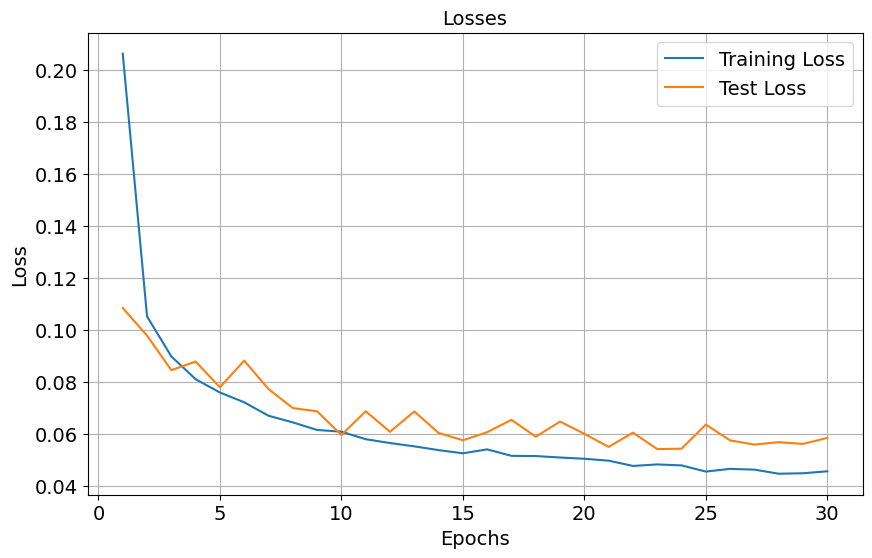

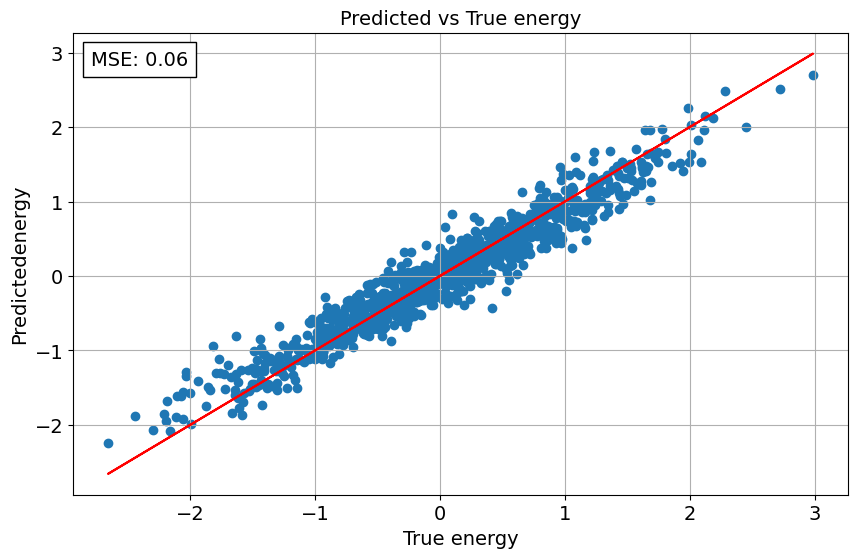

--------------------------------------------


n_dimensions: 1, periodic: True, number of connections: 10


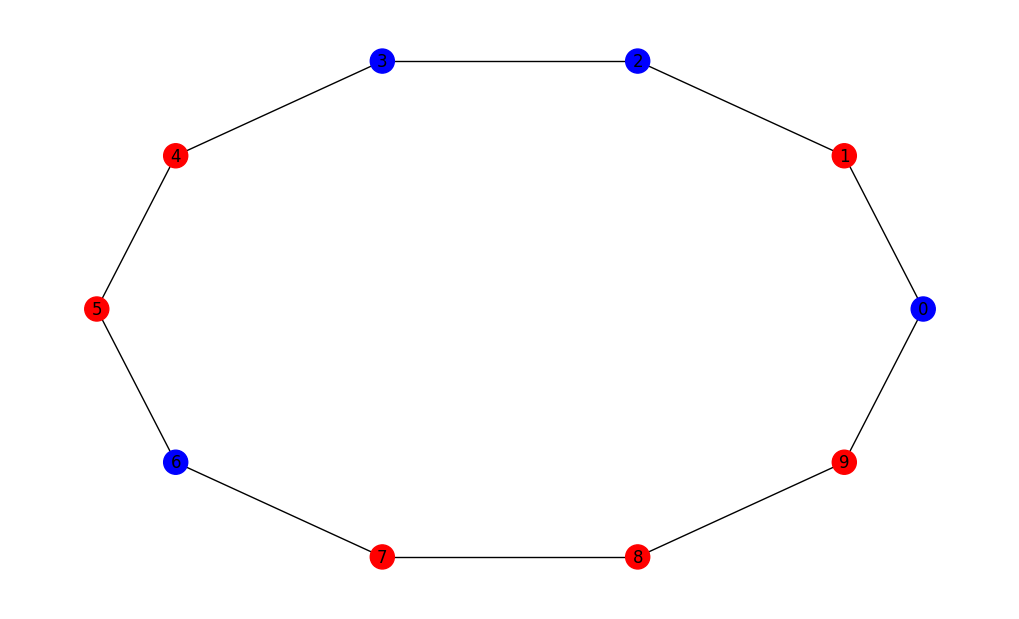

Training ...
Ep 1 	| Loss 0.23856 	| Test Loss 0.12101
Ep 2 	| Loss 0.12174 	| Test Loss 0.10586
Ep 3 	| Loss 0.1045 	| Test Loss 0.08485
Ep 4 	| Loss 0.09835 	| Test Loss 0.08561
Ep 5 	| Loss 0.09005 	| Test Loss 0.08402
Ep 6 	| Loss 0.08116 	| Test Loss 0.07726
Ep 7 	| Loss 0.07793 	| Test Loss 0.0819
Ep 8 	| Loss 0.07416 	| Test Loss 0.07708
Ep 9 	| Loss 0.07427 	| Test Loss 0.08399
Ep 10 	| Loss 0.07078 	| Test Loss 0.07488
Ep 11 	| Loss 0.06593 	| Test Loss 0.07853
Ep 12 	| Loss 0.06949 	| Test Loss 0.08638
Ep 13 	| Loss 0.06722 	| Test Loss 0.07911
Ep 14 	| Loss 0.06501 	| Test Loss 0.07971
Ep 15 	| Loss 0.06243 	| Test Loss 0.07944
Ep 16 	| Loss 0.06342 	| Test Loss 0.07798
Ep 17 	| Loss 0.0603 	| Test Loss 0.07816
Ep 18 	| Loss 0.05984 	| Test Loss 0.06811
Ep 19 	| Loss 0.05899 	| Test Loss 0.0714
Ep 20 	| Loss 0.05783 	| Test Loss 0.07536
Ep 21 	| Loss 0.05916 	| Test Loss 0.06493
Ep 22 	| Loss 0.05812 	| Test Loss 0.07265
Ep 23 	| Loss 0.05438 	| Test Loss 0.06932
Ep 24 	| Lo

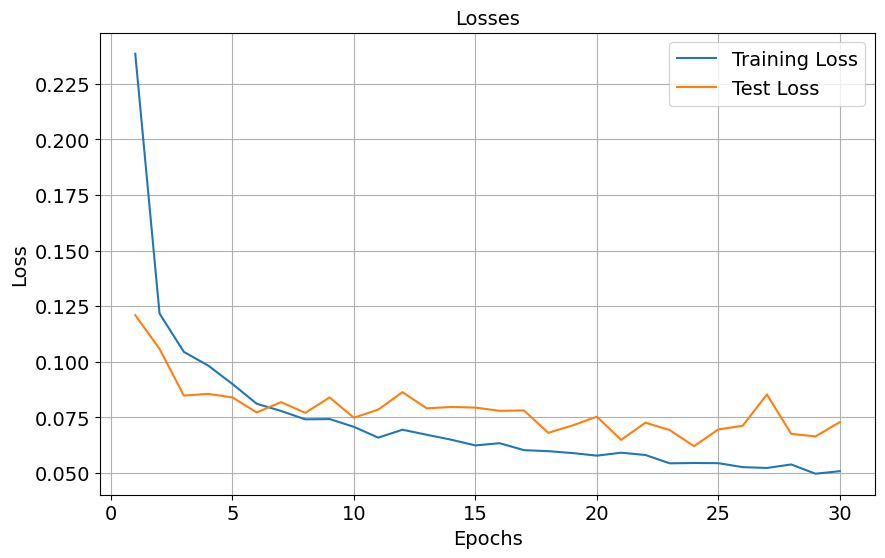

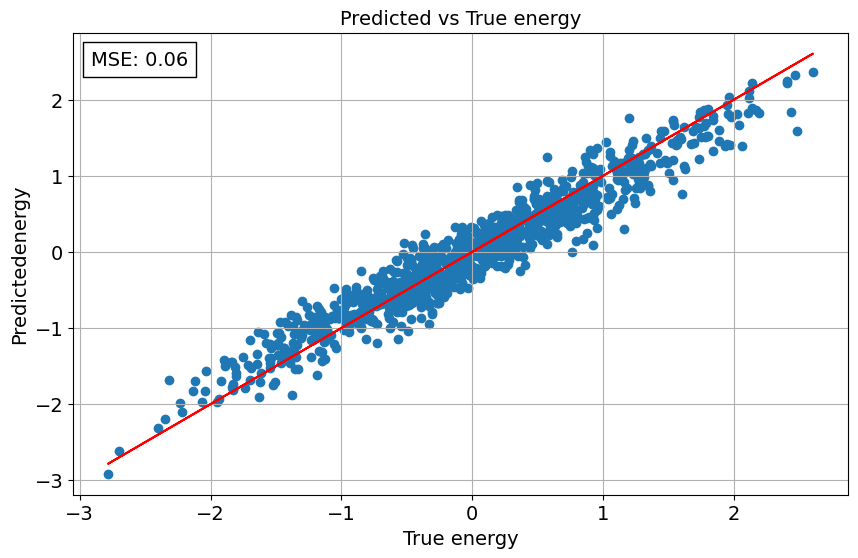

--------------------------------------------


n_dimensions: 2, periodic: False, number of connections: 17


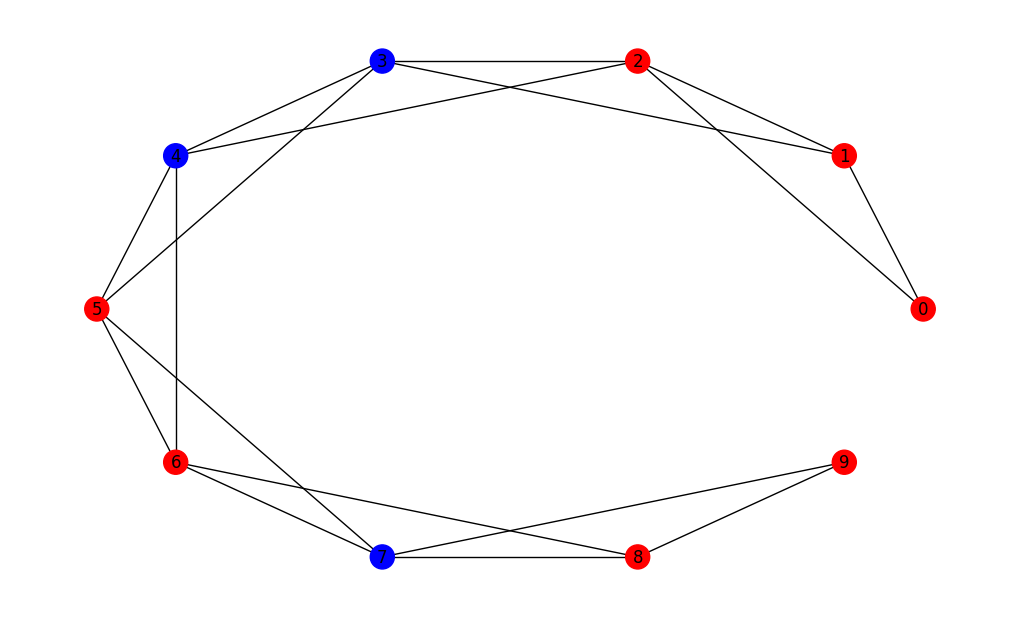

Training ...
Ep 1 	| Loss 0.45653 	| Test Loss 0.28088
Ep 2 	| Loss 0.21412 	| Test Loss 0.27954
Ep 3 	| Loss 0.18527 	| Test Loss 0.18673
Ep 4 	| Loss 0.16884 	| Test Loss 0.16927
Ep 5 	| Loss 0.15613 	| Test Loss 0.16368
Ep 6 	| Loss 0.1466 	| Test Loss 0.15066
Ep 7 	| Loss 0.13497 	| Test Loss 0.15151
Ep 8 	| Loss 0.12964 	| Test Loss 0.17646
Ep 9 	| Loss 0.12964 	| Test Loss 0.14823
Ep 10 	| Loss 0.1237 	| Test Loss 0.15511
Ep 11 	| Loss 0.11766 	| Test Loss 0.13899
Ep 12 	| Loss 0.11416 	| Test Loss 0.12217
Ep 13 	| Loss 0.10973 	| Test Loss 0.14257
Ep 14 	| Loss 0.11145 	| Test Loss 0.12892
Ep 15 	| Loss 0.10601 	| Test Loss 0.12478
Ep 16 	| Loss 0.10205 	| Test Loss 0.13859
Ep 17 	| Loss 0.10282 	| Test Loss 0.1391
Ep 18 	| Loss 0.09542 	| Test Loss 0.14957
Ep 19 	| Loss 0.09614 	| Test Loss 0.13996
Ep 20 	| Loss 0.09641 	| Test Loss 0.13678
Ep 21 	| Loss 0.09558 	| Test Loss 0.12316
Ep 22 	| Loss 0.09275 	| Test Loss 0.12715
Ep 23 	| Loss 0.08743 	| Test Loss 0.13852
Ep 24 	| L

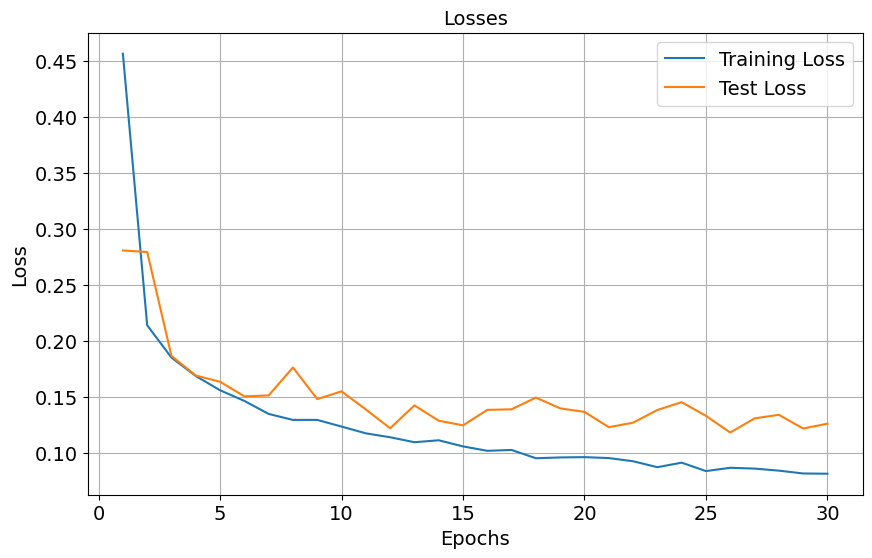

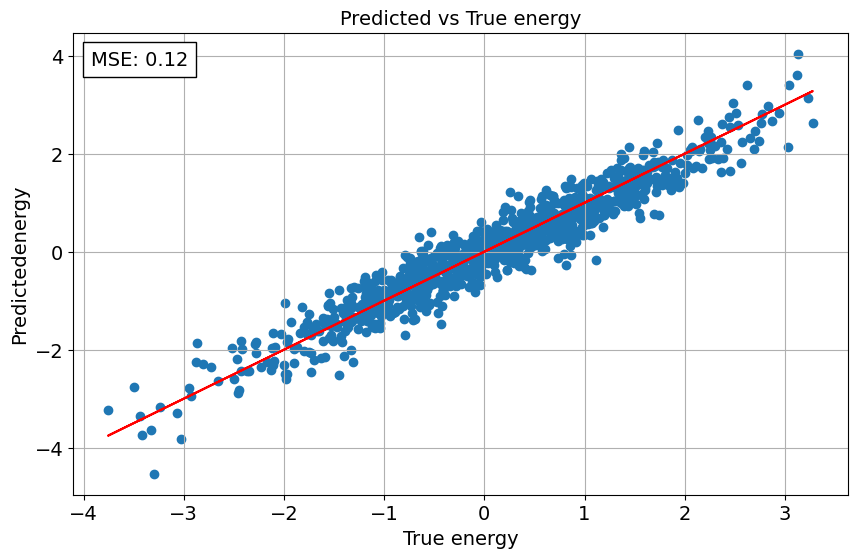

--------------------------------------------


n_dimensions: 2, periodic: True, number of connections: 20


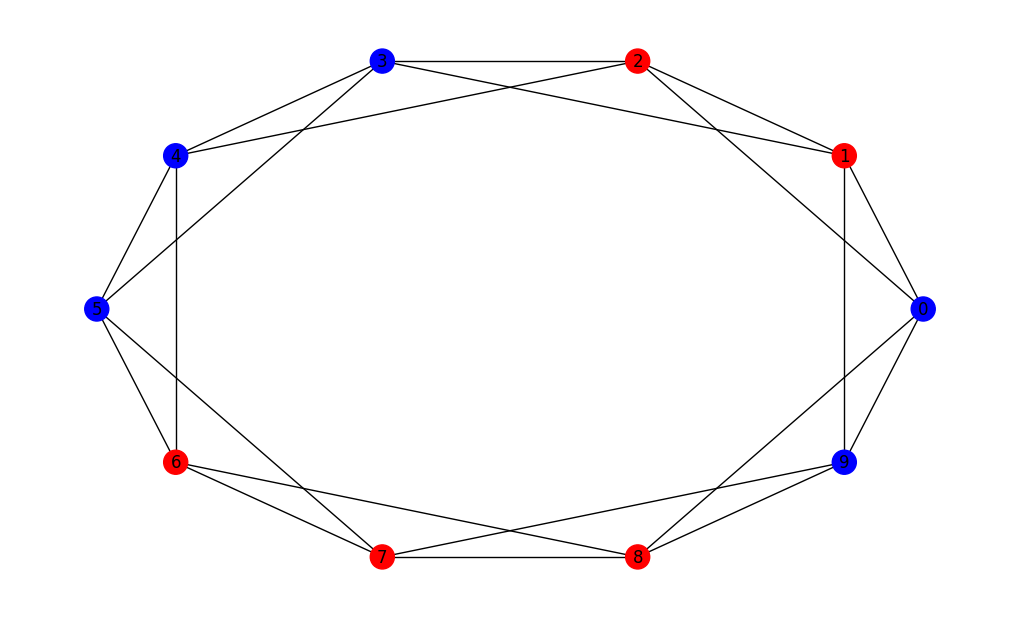

Training ...
Ep 1 	| Loss 0.57521 	| Test Loss 0.4251
Ep 2 	| Loss 0.26744 	| Test Loss 0.27304
Ep 3 	| Loss 0.22391 	| Test Loss 0.24934
Ep 4 	| Loss 0.20178 	| Test Loss 0.20301
Ep 5 	| Loss 0.18763 	| Test Loss 0.23379
Ep 6 	| Loss 0.17833 	| Test Loss 0.2015
Ep 7 	| Loss 0.17342 	| Test Loss 0.17249
Ep 8 	| Loss 0.16501 	| Test Loss 0.17124
Ep 9 	| Loss 0.16305 	| Test Loss 0.17606
Ep 10 	| Loss 0.15079 	| Test Loss 0.16651
Ep 11 	| Loss 0.14783 	| Test Loss 0.16946
Ep 12 	| Loss 0.14438 	| Test Loss 0.16672
Ep 13 	| Loss 0.13693 	| Test Loss 0.16421
Ep 14 	| Loss 0.13091 	| Test Loss 0.1799
Ep 15 	| Loss 0.13183 	| Test Loss 0.16881
Ep 16 	| Loss 0.12303 	| Test Loss 0.16869
Ep 17 	| Loss 0.12575 	| Test Loss 0.20851
Ep 18 	| Loss 0.12234 	| Test Loss 0.17326
Ep 19 	| Loss 0.11928 	| Test Loss 0.1661
Ep 20 	| Loss 0.11322 	| Test Loss 0.18397
Ep 21 	| Loss 0.11316 	| Test Loss 0.15849
Ep 22 	| Loss 0.11052 	| Test Loss 0.17027
Ep 23 	| Loss 0.10929 	| Test Loss 0.18084
Ep 24 	| Lo

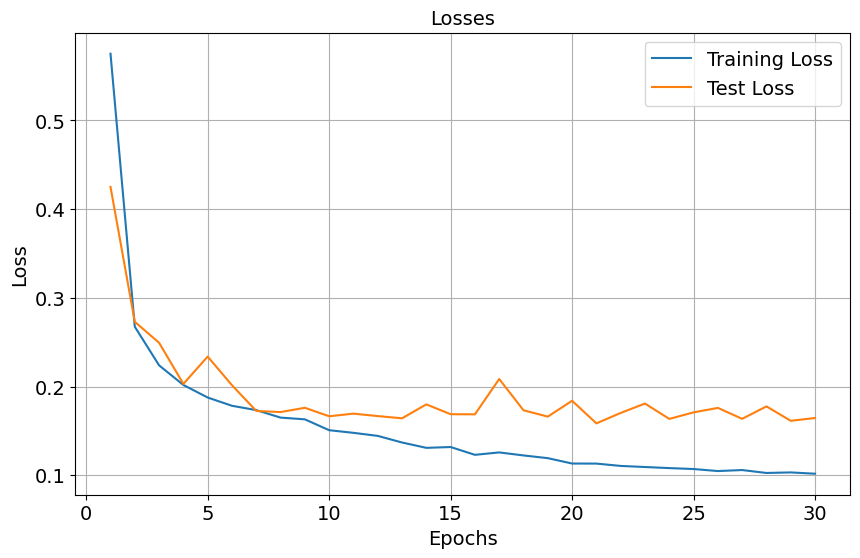

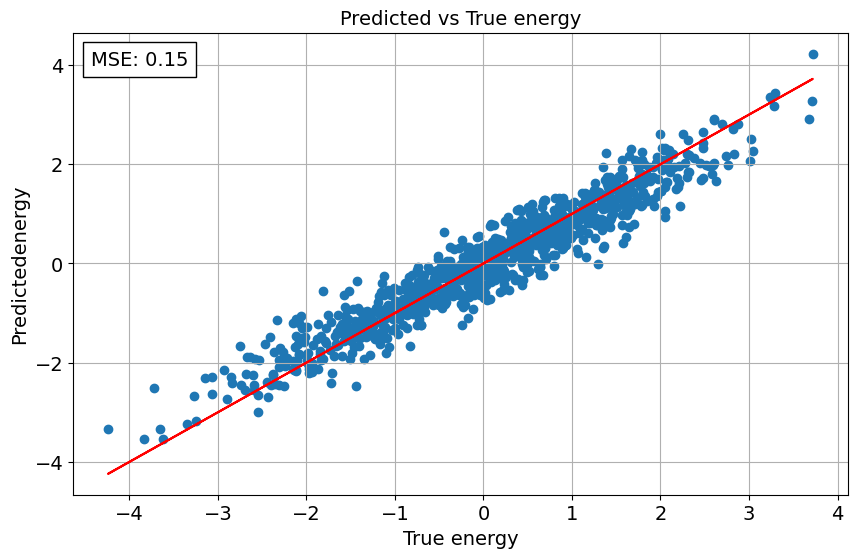

--------------------------------------------


n_dimensions: 3, periodic: False, number of connections: 24


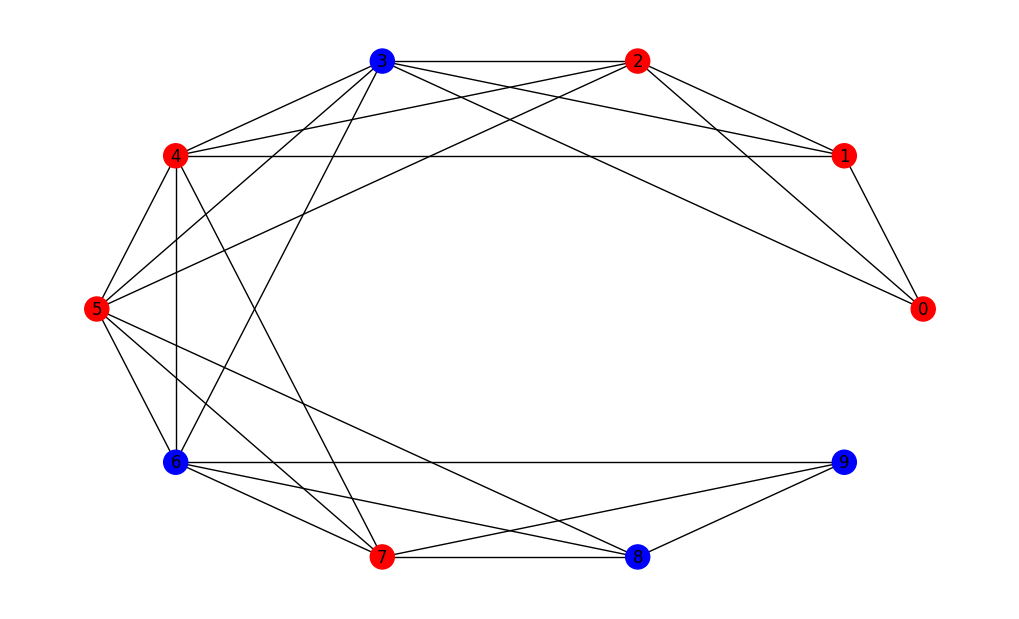

Training ...
Ep 1 	| Loss 0.61501 	| Test Loss 0.37573
Ep 2 	| Loss 0.30712 	| Test Loss 0.35911
Ep 3 	| Loss 0.26455 	| Test Loss 0.27289
Ep 4 	| Loss 0.23877 	| Test Loss 0.2738
Ep 5 	| Loss 0.21741 	| Test Loss 0.25673
Ep 6 	| Loss 0.20688 	| Test Loss 0.27124
Ep 7 	| Loss 0.19781 	| Test Loss 0.22414
Ep 8 	| Loss 0.19246 	| Test Loss 0.25486
Ep 9 	| Loss 0.18242 	| Test Loss 0.29078
Ep 10 	| Loss 0.17629 	| Test Loss 0.25614
Ep 11 	| Loss 0.1626 	| Test Loss 0.27425
Ep 12 	| Loss 0.16231 	| Test Loss 0.21088
Ep 13 	| Loss 0.15321 	| Test Loss 0.25073
Ep 14 	| Loss 0.15176 	| Test Loss 0.33741
Ep 15 	| Loss 0.1496 	| Test Loss 0.24675
Ep 16 	| Loss 0.1443 	| Test Loss 0.25895
Ep 17 	| Loss 0.14038 	| Test Loss 0.21828
Ep 18 	| Loss 0.13709 	| Test Loss 0.22019
Ep 19 	| Loss 0.13299 	| Test Loss 0.24531
Ep 20 	| Loss 0.13152 	| Test Loss 0.19897
Ep 21 	| Loss 0.12704 	| Test Loss 0.2519
Ep 22 	| Loss 0.12864 	| Test Loss 0.21456
Ep 23 	| Loss 0.12936 	| Test Loss 0.23232
Ep 24 	| Los

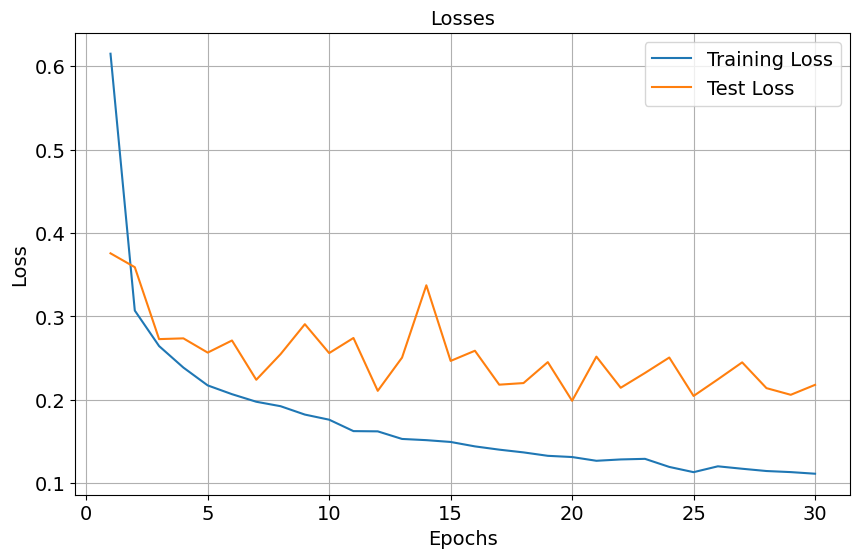

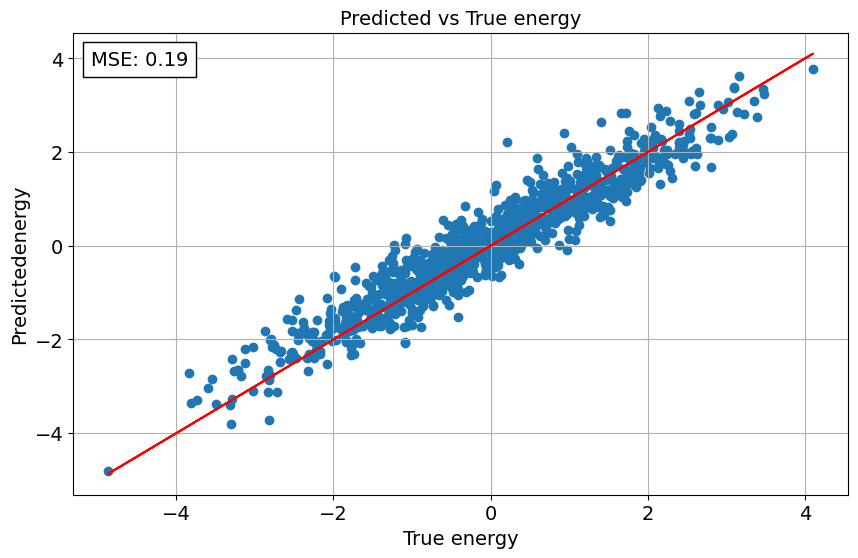

--------------------------------------------


n_dimensions: 3, periodic: True, number of connections: 30


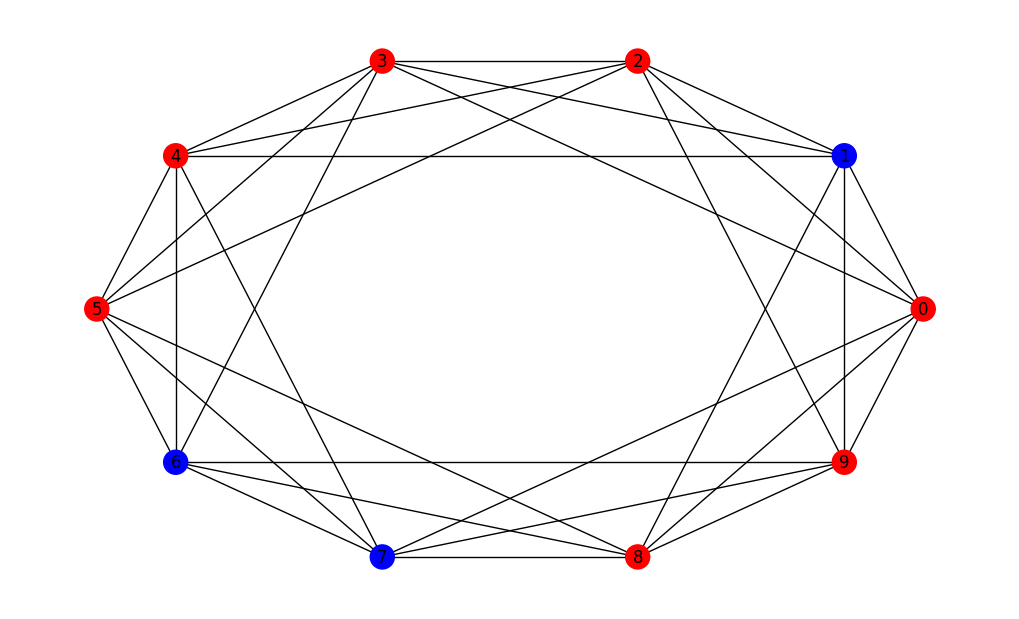

Training ...
Ep 1 	| Loss 0.85938 	| Test Loss 0.40576
Ep 2 	| Loss 0.3759 	| Test Loss 0.32656
Ep 3 	| Loss 0.32641 	| Test Loss 0.31936
Ep 4 	| Loss 0.29658 	| Test Loss 0.29834
Ep 5 	| Loss 0.26892 	| Test Loss 0.31412
Ep 6 	| Loss 0.25091 	| Test Loss 0.28098
Ep 7 	| Loss 0.2464 	| Test Loss 0.27101
Ep 8 	| Loss 0.22696 	| Test Loss 0.27266
Ep 9 	| Loss 0.219 	| Test Loss 0.26862
Ep 10 	| Loss 0.20926 	| Test Loss 0.26303
Ep 11 	| Loss 0.20533 	| Test Loss 0.27444
Ep 12 	| Loss 0.19572 	| Test Loss 0.2814
Ep 13 	| Loss 0.18789 	| Test Loss 0.24341
Ep 14 	| Loss 0.19159 	| Test Loss 0.26329
Ep 15 	| Loss 0.17819 	| Test Loss 0.25332
Ep 16 	| Loss 0.18149 	| Test Loss 0.25874
Ep 17 	| Loss 0.16995 	| Test Loss 0.2785
Ep 18 	| Loss 0.16189 	| Test Loss 0.24505
Ep 19 	| Loss 0.16741 	| Test Loss 0.23343
Ep 20 	| Loss 0.15652 	| Test Loss 0.24393
Ep 21 	| Loss 0.16095 	| Test Loss 0.2513
Ep 22 	| Loss 0.15637 	| Test Loss 0.3007
Ep 23 	| Loss 0.14794 	| Test Loss 0.27954
Ep 24 	| Loss 0

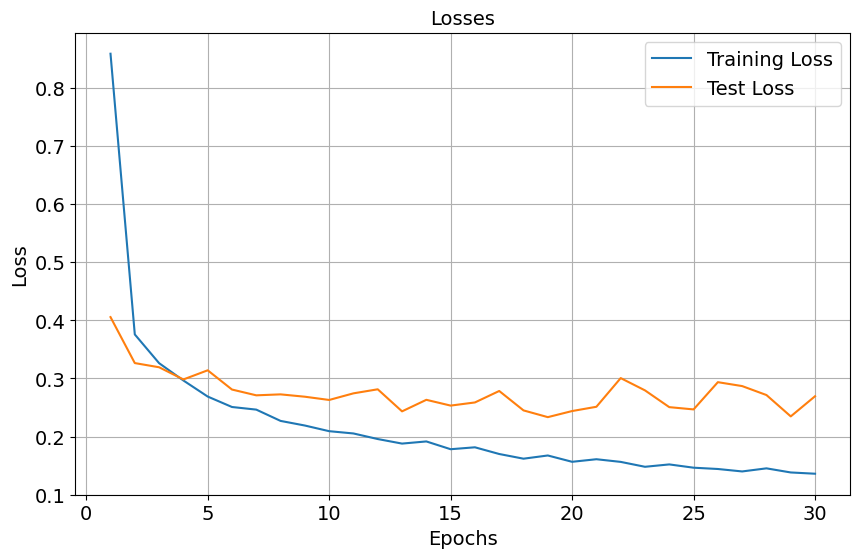

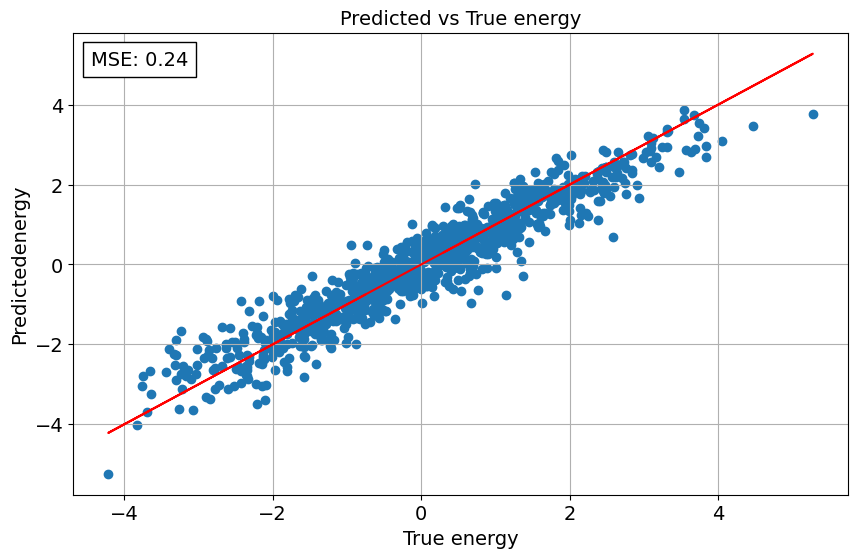

--------------------------------------------


n_dimensions: 4, periodic: False, number of connections: 30


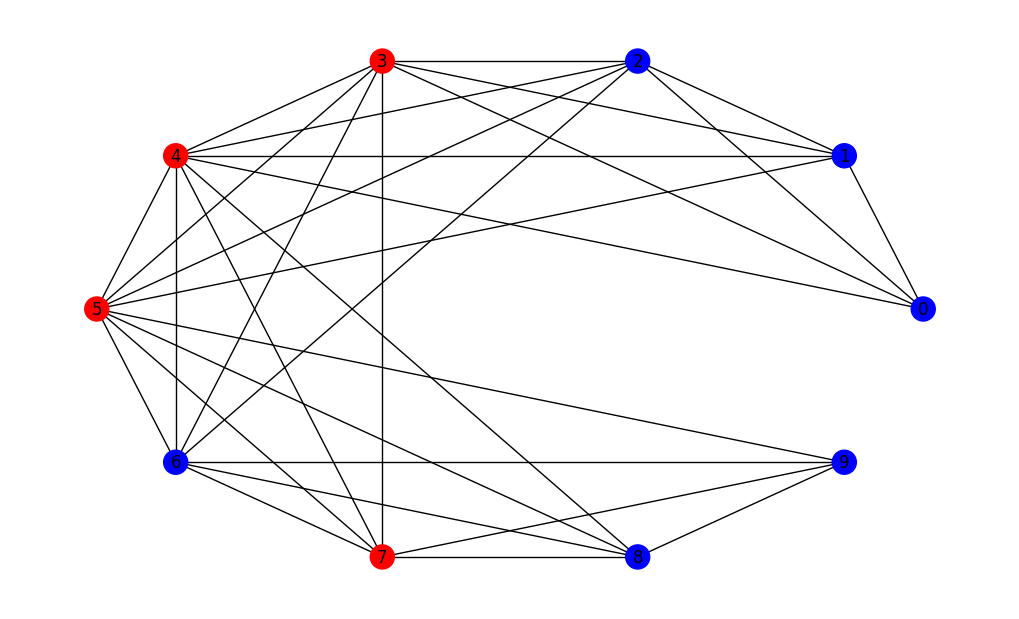

Training ...
Ep 1 	| Loss 0.7994 	| Test Loss 0.38384
Ep 2 	| Loss 0.36035 	| Test Loss 0.30717
Ep 3 	| Loss 0.31511 	| Test Loss 0.2847
Ep 4 	| Loss 0.29196 	| Test Loss 0.27471
Ep 5 	| Loss 0.26747 	| Test Loss 0.2731
Ep 6 	| Loss 0.24887 	| Test Loss 0.26396
Ep 7 	| Loss 0.24031 	| Test Loss 0.25115
Ep 8 	| Loss 0.22918 	| Test Loss 0.25897
Ep 9 	| Loss 0.22198 	| Test Loss 0.25957
Ep 10 	| Loss 0.20763 	| Test Loss 0.24699
Ep 11 	| Loss 0.20572 	| Test Loss 0.24249
Ep 12 	| Loss 0.20035 	| Test Loss 0.21544
Ep 13 	| Loss 0.19589 	| Test Loss 0.22851
Ep 14 	| Loss 0.18123 	| Test Loss 0.22824
Ep 15 	| Loss 0.17853 	| Test Loss 0.23609
Ep 16 	| Loss 0.17568 	| Test Loss 0.22606
Ep 17 	| Loss 0.17015 	| Test Loss 0.23833
Ep 18 	| Loss 0.16481 	| Test Loss 0.2168
Ep 19 	| Loss 0.16456 	| Test Loss 0.21015
Ep 20 	| Loss 0.15612 	| Test Loss 0.22188
Ep 21 	| Loss 0.15729 	| Test Loss 0.19651
Ep 22 	| Loss 0.15783 	| Test Loss 0.20624
Ep 23 	| Loss 0.14871 	| Test Loss 0.21944
Ep 24 	| Lo

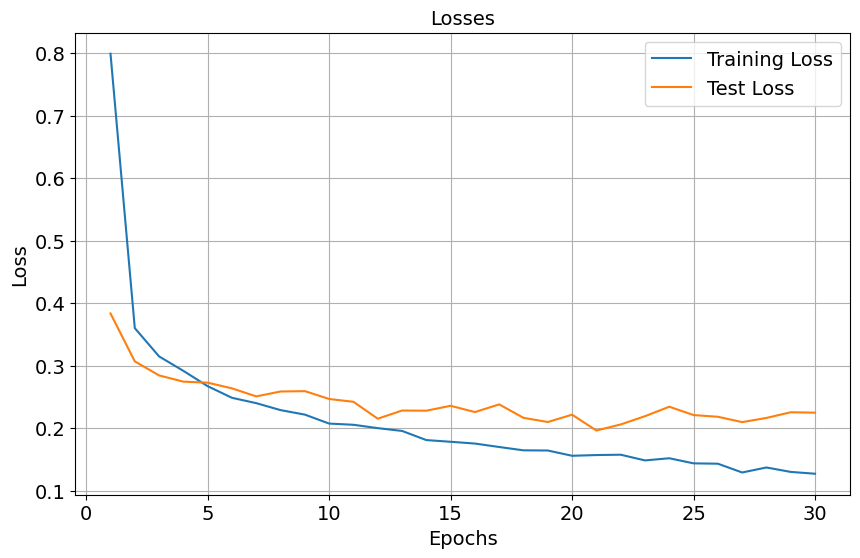

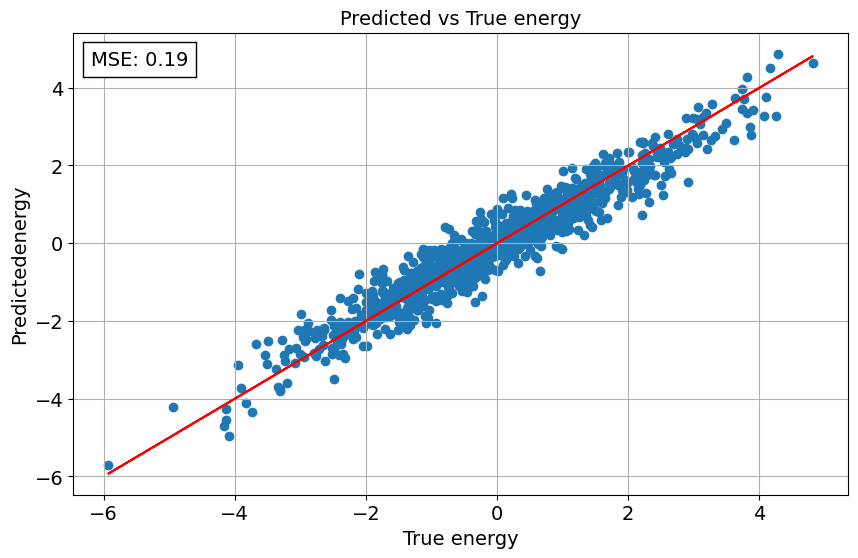

--------------------------------------------


n_dimensions: 4, periodic: True, number of connections: 40


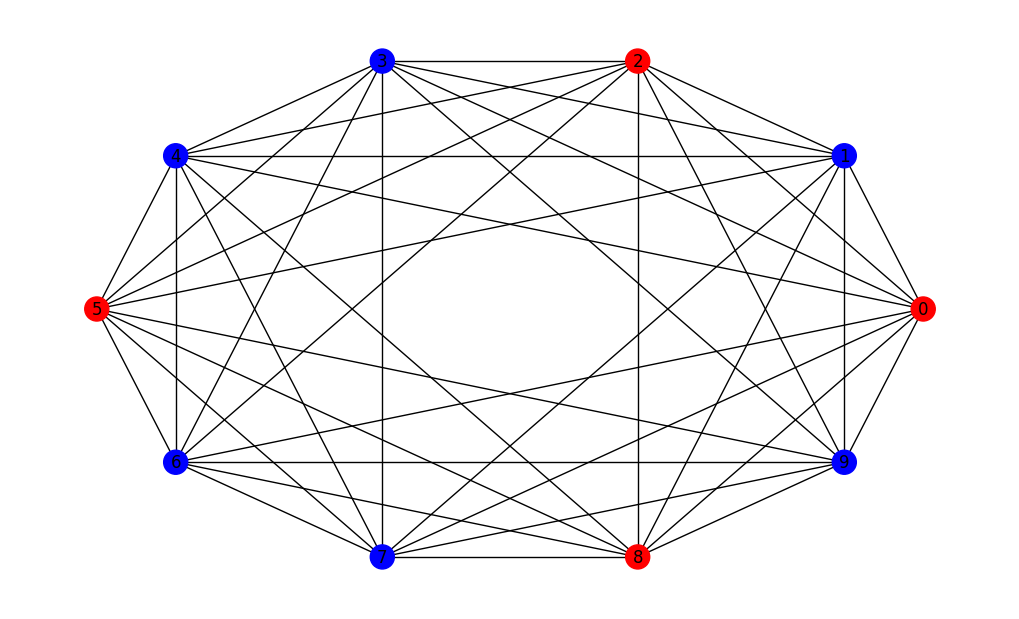

Training ...
Ep 1 	| Loss 1.19007 	| Test Loss 0.49284
Ep 2 	| Loss 0.48694 	| Test Loss 0.41549
Ep 3 	| Loss 0.43656 	| Test Loss 0.41227
Ep 4 	| Loss 0.38266 	| Test Loss 0.4068
Ep 5 	| Loss 0.36592 	| Test Loss 0.35647
Ep 6 	| Loss 0.34533 	| Test Loss 0.37582
Ep 7 	| Loss 0.31781 	| Test Loss 0.37753
Ep 8 	| Loss 0.31034 	| Test Loss 0.34479
Ep 9 	| Loss 0.29896 	| Test Loss 0.36165
Ep 10 	| Loss 0.28595 	| Test Loss 0.36471
Ep 11 	| Loss 0.27687 	| Test Loss 0.36754
Ep 12 	| Loss 0.25855 	| Test Loss 0.35752
Ep 13 	| Loss 0.25252 	| Test Loss 0.34888
Ep 14 	| Loss 0.24888 	| Test Loss 0.35242
Ep 15 	| Loss 0.23574 	| Test Loss 0.33495
Ep 16 	| Loss 0.22946 	| Test Loss 0.31877
Ep 17 	| Loss 0.22221 	| Test Loss 0.31676
Ep 18 	| Loss 0.21593 	| Test Loss 0.3072
Ep 19 	| Loss 0.21237 	| Test Loss 0.3239
Ep 20 	| Loss 0.20821 	| Test Loss 0.31394
Ep 21 	| Loss 0.2011 	| Test Loss 0.30566
Ep 22 	| Loss 0.19534 	| Test Loss 0.30156
Ep 23 	| Loss 0.19834 	| Test Loss 0.3066
Ep 24 	| Los

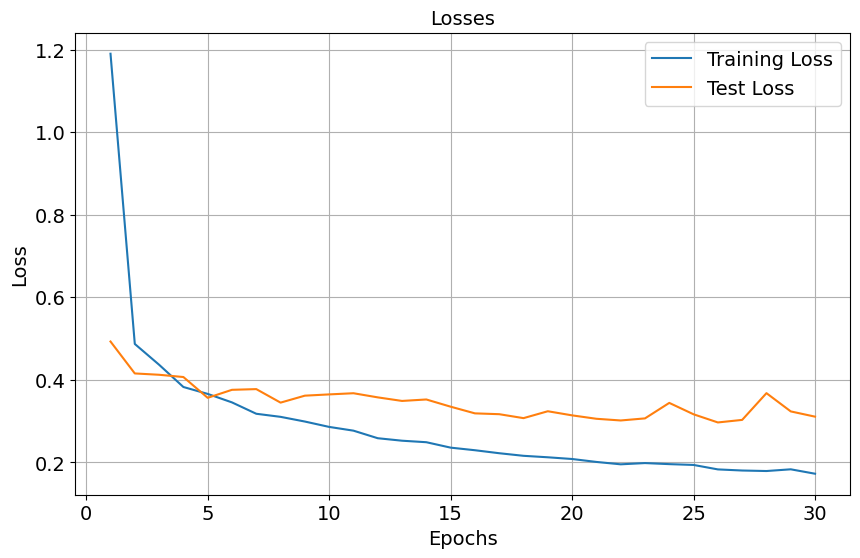

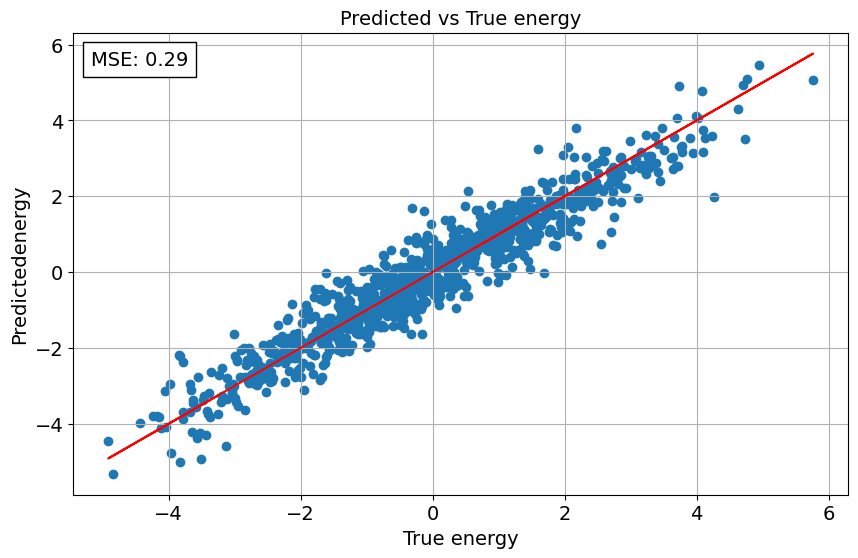

--------------------------------------------


n_dimensions: 5, periodic: False, number of connections: 35


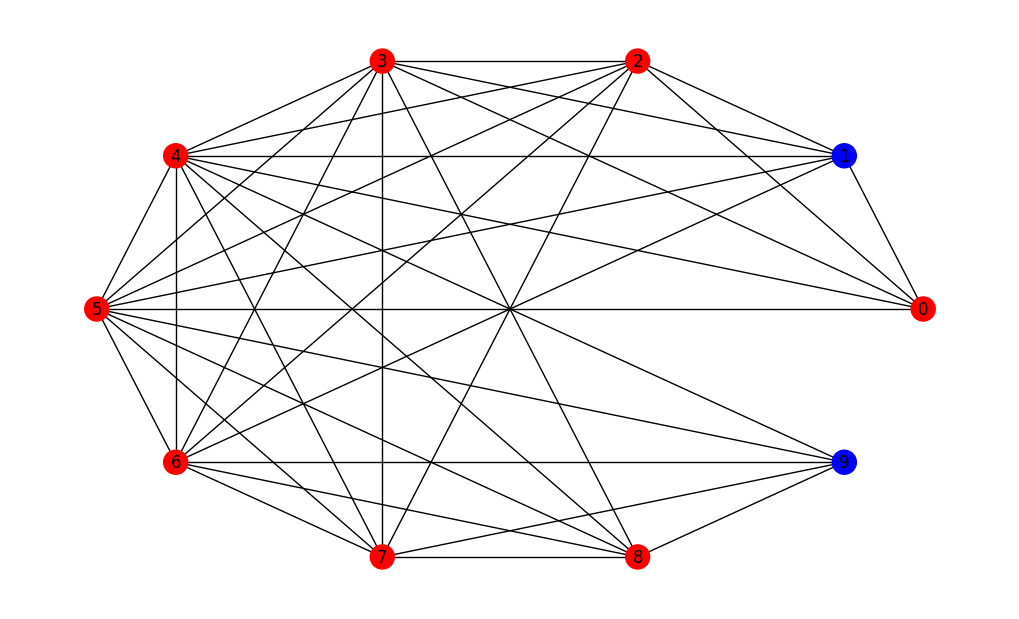

Training ...
Ep 1 	| Loss 0.84345 	| Test Loss 0.41496
Ep 2 	| Loss 0.4136 	| Test Loss 0.37191
Ep 3 	| Loss 0.36617 	| Test Loss 0.40008
Ep 4 	| Loss 0.33757 	| Test Loss 0.3359
Ep 5 	| Loss 0.30606 	| Test Loss 0.41978
Ep 6 	| Loss 0.28979 	| Test Loss 0.38625
Ep 7 	| Loss 0.26275 	| Test Loss 0.3753
Ep 8 	| Loss 0.25799 	| Test Loss 0.38258
Ep 9 	| Loss 0.25207 	| Test Loss 0.36217
Ep 10 	| Loss 0.23511 	| Test Loss 0.33167
Ep 11 	| Loss 0.23434 	| Test Loss 0.35122
Ep 12 	| Loss 0.21576 	| Test Loss 0.3665
Ep 13 	| Loss 0.2212 	| Test Loss 0.36103
Ep 14 	| Loss 0.21046 	| Test Loss 0.33873
Ep 15 	| Loss 0.20772 	| Test Loss 0.31707
Ep 16 	| Loss 0.19889 	| Test Loss 0.30012
Ep 17 	| Loss 0.19075 	| Test Loss 0.30478
Ep 18 	| Loss 0.18591 	| Test Loss 0.27928
Ep 19 	| Loss 0.18028 	| Test Loss 0.29553
Ep 20 	| Loss 0.17842 	| Test Loss 0.32151
Ep 21 	| Loss 0.17538 	| Test Loss 0.2903
Ep 22 	| Loss 0.17671 	| Test Loss 0.34139
Ep 23 	| Loss 0.16321 	| Test Loss 0.24799
Ep 24 	| Loss

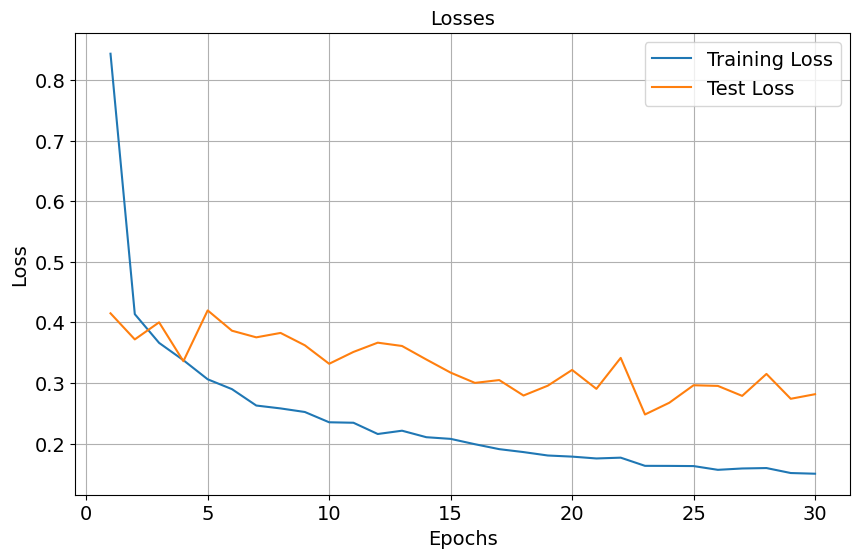

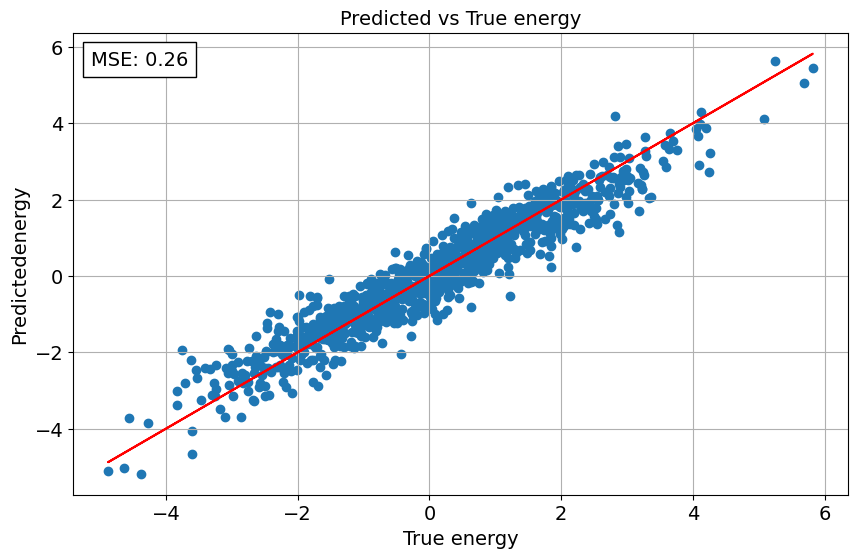

--------------------------------------------


n_dimensions: 5, periodic: True, number of connections: 45


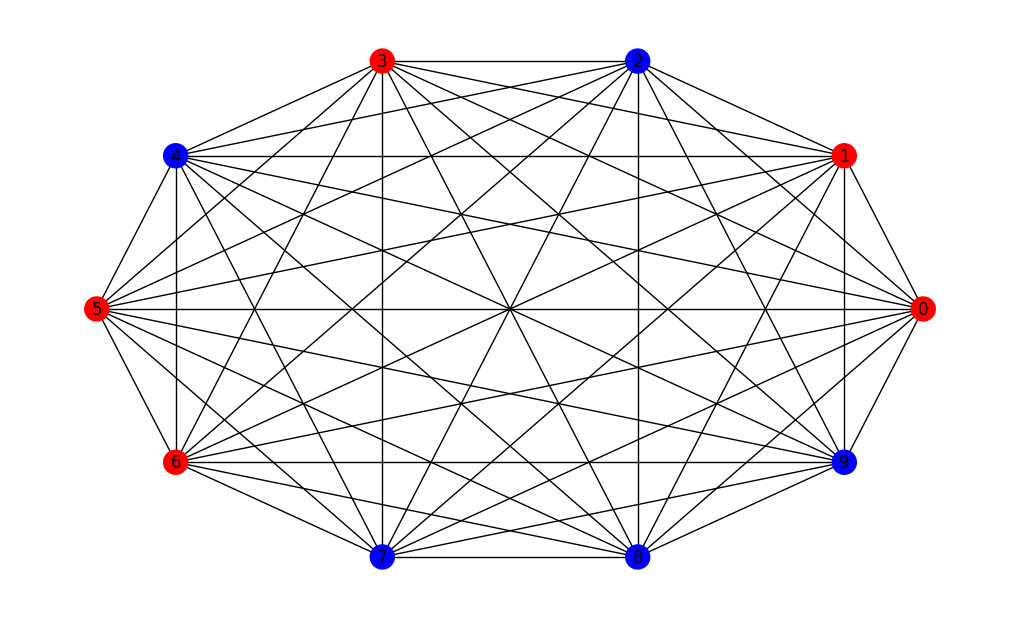

Training ...
Ep 1 	| Loss 1.25614 	| Test Loss 0.50013
Ep 2 	| Loss 0.51071 	| Test Loss 0.47838
Ep 3 	| Loss 0.46047 	| Test Loss 0.46713
Ep 4 	| Loss 0.41168 	| Test Loss 0.46953
Ep 5 	| Loss 0.37418 	| Test Loss 0.47562
Ep 6 	| Loss 0.34865 	| Test Loss 0.52535
Ep 7 	| Loss 0.34384 	| Test Loss 0.46073
Ep 8 	| Loss 0.32757 	| Test Loss 0.47159
Ep 9 	| Loss 0.30257 	| Test Loss 0.44486
Ep 10 	| Loss 0.28355 	| Test Loss 0.57432
Ep 11 	| Loss 0.27854 	| Test Loss 0.44866
Ep 12 	| Loss 0.27323 	| Test Loss 0.45314
Ep 13 	| Loss 0.26478 	| Test Loss 0.37936
Ep 14 	| Loss 0.25931 	| Test Loss 0.45341
Ep 15 	| Loss 0.24839 	| Test Loss 0.33475
Ep 16 	| Loss 0.245 	| Test Loss 0.57229
Ep 17 	| Loss 0.22931 	| Test Loss 0.48168
Ep 18 	| Loss 0.23585 	| Test Loss 0.57678
Ep 19 	| Loss 0.22387 	| Test Loss 0.46149
Ep 20 	| Loss 0.21253 	| Test Loss 0.36639
Ep 21 	| Loss 0.20801 	| Test Loss 0.42279
Ep 22 	| Loss 0.20662 	| Test Loss 0.37524
Ep 23 	| Loss 0.20398 	| Test Loss 0.33616
Ep 24 	| 

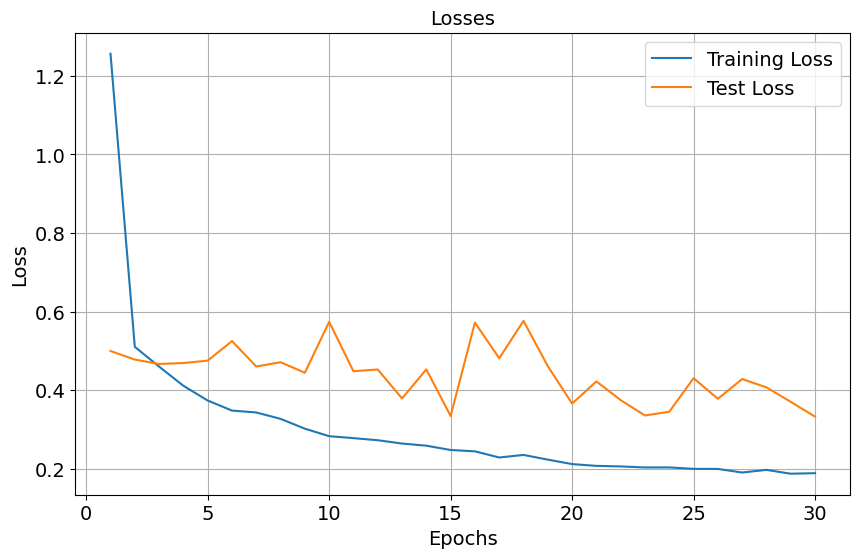

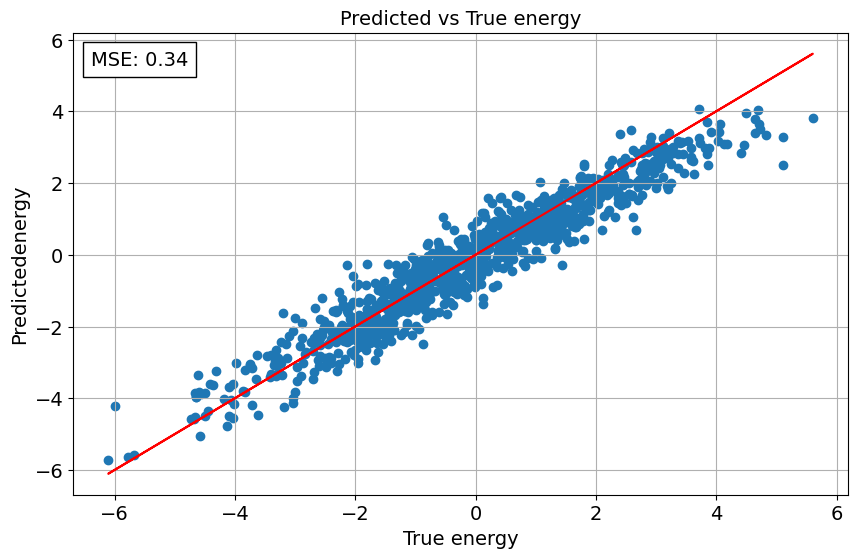

--------------------------------------------




In [24]:
i = 0 # index to keep track of the dataset

for n_dimensions in list_dimensions:
    for periodic in list_periodic:

        dataset = list_datasets[i]
        graphs = list_graphs[i]

        # get number of connections
        n_connections = len(graphs[0].edges)
        list_n_connections.append(n_connections)

        print(f"n_dimensions: {n_dimensions}, periodic: {periodic}, number of connections: {n_connections}")

        # plot the first graph
        fig = plot_graph(graphs[0])


        # split the dataset into training and test set and create the loaders
        train_loader = DataLoader(dataset[:int(0.8*n_samples)], batch_size=batch_size, shuffle=False) # shuffle not needed
        test_loader = DataLoader(dataset[int(0.8*n_samples):], batch_size=batch_size, shuffle=False)

        # copy the model from scratch
        model = GNN(hidden_channels_1=hidden_channels_1, hidden_channels_2=hidden_channels_2, hidden_channels_3=hidden_channels_3,
            hidden_channels_4=hidden_channels_4, hidden_linear=hidden_linear, lr=lr, weight_decay=weight_decay, dropout=dropout)

        model.to(device)

        # set the model name
        model_name = set_model_name(n_nodes, n_dimensions, h, periodic, n_samples, hidden_channels_1, hidden_channels_2, hidden_channels_3, hidden_channels_4, hidden_linear, lr, weight_decay, dropout,num_epochs)
        list_model_names.append(model_name)

        try:
            os.mkdir(model_name)
        except:
            pass

        # save the graph plot 
        fig.savefig(model_name + "/graph.png")

        # train the model
        train_losses, test_losses = train_model(model, train_loader, test_loader, num_epochs, patience=patience, model_name=model_name, verbose=True, device=device)
        list_train_losses.append(train_losses)
        list_test_losses.append(test_losses)

        # save train and test losses 
        np.save(model_name + '/train_losses.npy', train_losses)
        np.save(model_name + '/test_losses.npy', test_losses)
          

        # plot the losses
        fig_losses = plot_loss(train_losses, test_losses)
        fig_losses.savefig(model_name + "/losses.png")
        list_fig_losses.append(fig_losses)

        # test the trained model
        fig, mse = test_trained_model(model_name, test_loader, device=device)
        fig.savefig(model_name + "/test.png")
        list_fig_tests.append(fig)

        # store the mse
        list_mse.append(mse)

        print(44 * '-')
        print("\n")

        folder_name = f"n_nodes_{n_nodes}_n_dimensions_{n_dimensions}"
        try: os.mkdir(folder_name)
        except: pass

        # move the files to the folder
        os.system(f"mv {model_name} {folder_name}/{model_name}")     

        i += 1 # update the index for the dataset
                     

        

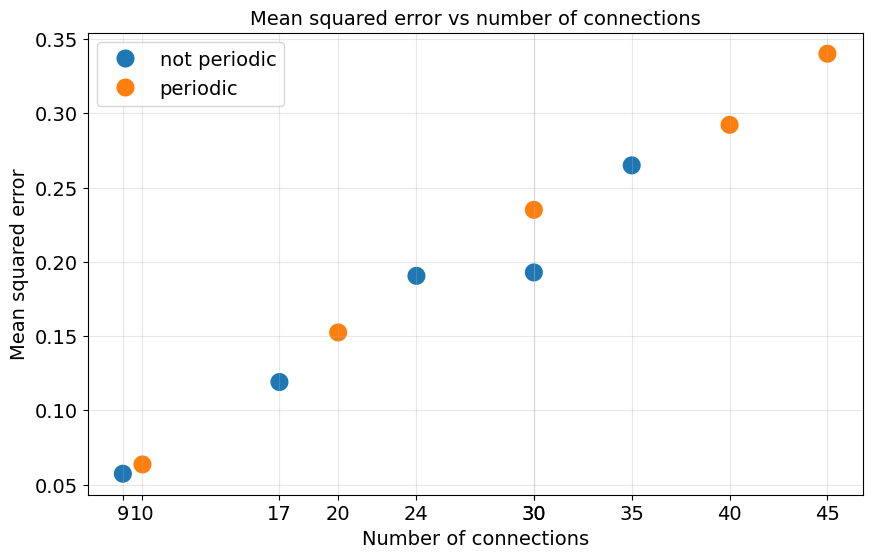

In [25]:
# plot the mse vs the number of connections
fig = plt.figure()
# set a label for even positions on list_n_connections
labels = ["not periodic" if i%2 == 0 else "periodic" for i in np.arange(len(list_n_connections))]


sns.scatterplot(x = list_n_connections, y= list_mse, hue=labels, size=labels, sizes=(200, 200) )

plt.xlabel('Number of connections')
plt.ylabel('Mean squared error')
plt.title('Mean squared error vs number of connections')
plt.xticks(list_n_connections)
plt.grid(alpha=0.3)


plt.show(fig)
fig.savefig(f"mse_vs_connections_{n_samples}_{h}.png")


In [26]:

# move everything to a new folder called n_nodes_10
try: os.mkdir("n_nodes_10")
except: pass

for dim in list_dimensions:
    os.system(f"mv n_nodes_10_n_dimensions_{dim}/* n_nodes_10/n_nodes_10_n_dimensions_{dim}/")
    os.system(f"rm -r n_nodes_10_n_dimensions_{dim}")
#os.system("mv datasets n_nodes_10")

os.system(f"mv mse_vs_connections_{n_samples}_{h}.png n_nodes_10")



0

# Magnetization learning (to be compared with task 2) <a class="anchor" id="magnetization"></a>
The prediction of the magnetization from a GNN is not part of the first task, but here we train a GNN for this purpose in order to compare it with the same task using a MLP in the second task.

In [27]:


# prepare lists to store the results
list_dimensions = [1,2,3,4,5]
list_periodic = [False, True]
list_datasets = []
list_graphs = []
list_n_connections = []
list_model_names = []
list_train_losses = []
list_test_losses = []
list_fig_losses = []
list_fig_tests = []
list_mse = []
create = True
save = True


if create:
    for n_dimensions in list_dimensions:
        for periodic in list_periodic:
            print(f"creating magnetization datasets with: n_dimensions: {n_dimensions}, periodic: {periodic}")
            
            dataset, graphs = create_dataset(n_nodes=n_nodes, h=h, periodic=periodic, n_dimensions=n_dimensions, n_samples=n_samples, save=False, mode="magnetization")
            list_datasets.append(dataset)
            list_graphs.append(graphs)

            if save:
                torch.save(dataset, f"datasets/dataset_magnetization_{n_nodes}_{h}_{periodic}_{n_dimensions}_{n_samples}.pt")
                torch.save(graphs, f"datasets/graphs_magnetization_{n_nodes}_{h}_{periodic}_{n_dimensions}_{n_samples}.pt")
else:
    print("loading datasets")
    for n_dimensions in list_dimensions:
        for periodic in list_periodic:
            dataset = torch.load(f"datasets/dataset_magnetization_{n_nodes}_{h}_{periodic}_{n_dimensions}_{n_samples}.pt")
            graphs = torch.load(f"datasets/graphs_magnetization_{n_nodes}_{h}_{periodic}_{n_dimensions}_{n_samples}.pt")
            list_datasets.append(dataset)
            list_graphs.append(graphs)
print("Done!")



creating magnetization datasets with: n_dimensions: 1, periodic: False
creating magnetization datasets with: n_dimensions: 1, periodic: True
creating magnetization datasets with: n_dimensions: 2, periodic: False
creating magnetization datasets with: n_dimensions: 2, periodic: True
creating magnetization datasets with: n_dimensions: 3, periodic: False
creating magnetization datasets with: n_dimensions: 3, periodic: True
creating magnetization datasets with: n_dimensions: 4, periodic: False
creating magnetization datasets with: n_dimensions: 4, periodic: True
creating magnetization datasets with: n_dimensions: 5, periodic: False
creating magnetization datasets with: n_dimensions: 5, periodic: True
Done!


n_dimensions: 1, periodic: False, number of connections: 9
Training ...


/home/claudio/anaconda3/envs/pytorch/lib/python3.12/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
/home/claudio/anaconda3/envs/pytorch/lib/python3.12/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Ep 1 	| Loss 3.31234 	| Test Loss 1.89354
Ep 2 	| Loss 1.71649 	| Test Loss 1.51224
Ep 3 	| Loss 1.40513 	| Test Loss 1.44972
Ep 4 	| Loss 1.27141 	| Test Loss 1.50213
Ep 5 	| Loss 1.20155 	| Test Loss 1.17098
Ep 6 	| Loss 1.0864 	| Test Loss 1.11101
Ep 7 	| Loss 1.06131 	| Test Loss 1.09742
Ep 8 	| Loss 0.9993 	| Test Loss 1.08381
Ep 9 	| Loss 0.97913 	| Test Loss 1.20549
Ep 10 	| Loss 0.94661 	| Test Loss 0.98649
Ep 11 	| Loss 0.94445 	| Test Loss 1.08926
Ep 12 	| Loss 0.89538 	| Test Loss 0.94938
Ep 13 	| Loss 0.84851 	| Test Loss 1.0451
Ep 14 	| Loss 0.84021 	| Test Loss 0.97907
Ep 15 	| Loss 0.81841 	| Test Loss 1.06414
Ep 16 	| Loss 0.80314 	| Test Loss 1.02669
Ep 17 	| Loss 0.80793 	| Test Loss 1.08658
Ep 18 	| Loss 0.76918 	| Test Loss 0.93149
Ep 19 	| Loss 0.77036 	| Test Loss 0.90515
Ep 20 	| Loss 0.74242 	| Test Loss 0.99318
Ep 21 	| Loss 0.70741 	| Test Loss 0.98252
Ep 22 	| Loss 0.72692 	| Test Loss 1.00828
Ep 23 	| Loss 0.71118 	| Test Loss 0.86367
Ep 24 	| Loss 0.69097 	

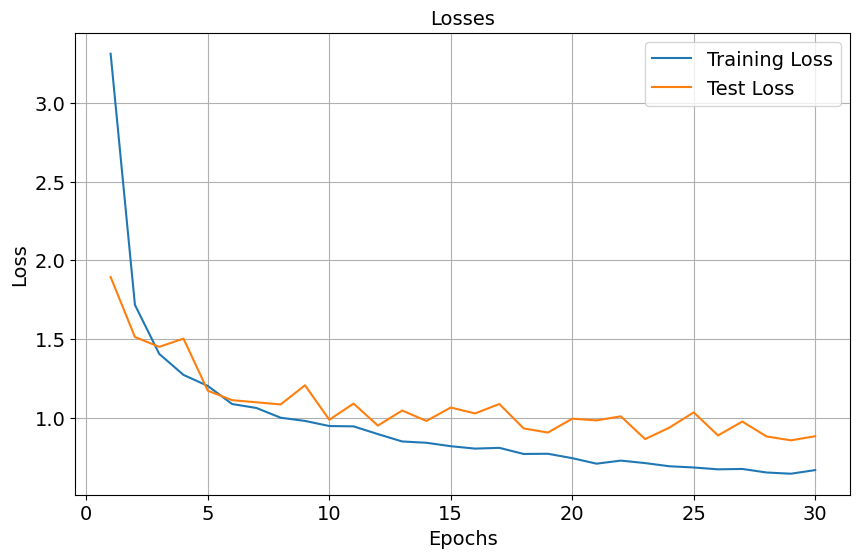

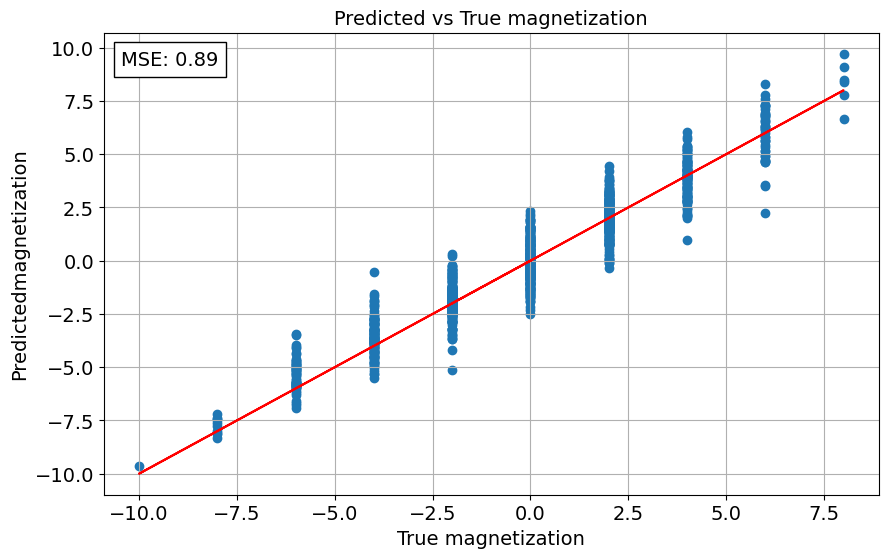

--------------------------------------------


n_dimensions: 1, periodic: True, number of connections: 10
Training ...
Ep 1 	| Loss 3.52093 	| Test Loss 2.08173
Ep 2 	| Loss 1.87049 	| Test Loss 1.61929
Ep 3 	| Loss 1.62577 	| Test Loss 1.69899
Ep 4 	| Loss 1.39477 	| Test Loss 1.32133
Ep 5 	| Loss 1.26851 	| Test Loss 1.26983
Ep 6 	| Loss 1.15404 	| Test Loss 1.09468
Ep 7 	| Loss 1.11711 	| Test Loss 1.06061
Ep 8 	| Loss 1.04626 	| Test Loss 1.03135
Ep 9 	| Loss 1.01378 	| Test Loss 1.15084
Ep 10 	| Loss 1.00148 	| Test Loss 0.99917
Ep 11 	| Loss 0.92268 	| Test Loss 0.98069
Ep 12 	| Loss 0.90099 	| Test Loss 0.86599
Ep 13 	| Loss 0.84523 	| Test Loss 1.01602
Ep 14 	| Loss 0.81056 	| Test Loss 0.86705
Ep 15 	| Loss 0.80712 	| Test Loss 0.86887
Ep 16 	| Loss 0.79949 	| Test Loss 1.15573
Ep 17 	| Loss 0.75944 	| Test Loss 0.89792
Ep 18 	| Loss 0.7735 	| Test Loss 0.88207
Ep 19 	| Loss 0.73575 	| Test Loss 0.79562
Ep 20 	| Loss 0.72302 	| Test Loss 0.7977
Ep 21 	| Loss 0.70985 	| Test Lo

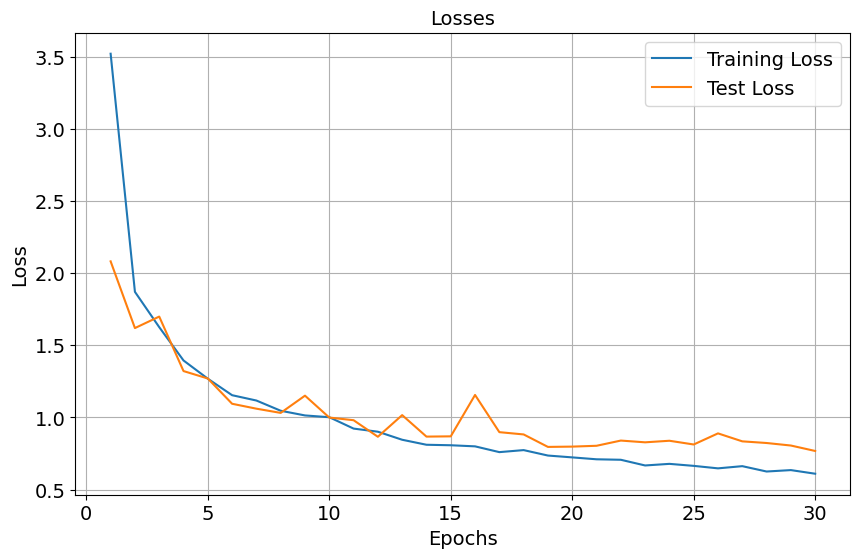

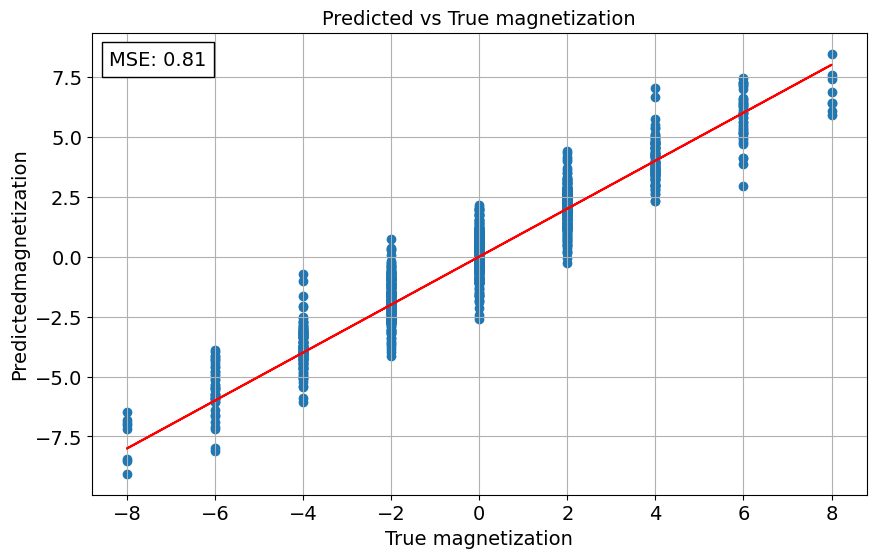

--------------------------------------------


n_dimensions: 2, periodic: False, number of connections: 17
Training ...
Ep 1 	| Loss 3.74483 	| Test Loss 2.6728
Ep 2 	| Loss 2.0465 	| Test Loss 2.49775
Ep 3 	| Loss 1.72396 	| Test Loss 2.38667
Ep 4 	| Loss 1.53328 	| Test Loss 2.15557
Ep 5 	| Loss 1.39542 	| Test Loss 2.15653
Ep 6 	| Loss 1.28696 	| Test Loss 1.54318
Ep 7 	| Loss 1.23726 	| Test Loss 1.73873
Ep 8 	| Loss 1.16346 	| Test Loss 1.58745
Ep 9 	| Loss 1.16396 	| Test Loss 1.80155
Ep 10 	| Loss 1.10843 	| Test Loss 1.78584
Ep 11 	| Loss 1.04297 	| Test Loss 1.40052
Ep 12 	| Loss 1.00088 	| Test Loss 1.45993
Ep 13 	| Loss 0.98155 	| Test Loss 1.71054
Ep 14 	| Loss 0.94687 	| Test Loss 1.34016
Ep 15 	| Loss 0.90894 	| Test Loss 1.70352
Ep 16 	| Loss 0.91171 	| Test Loss 1.52722
Ep 17 	| Loss 0.87985 	| Test Loss 1.54579
Ep 18 	| Loss 0.844 	| Test Loss 1.39062
Ep 19 	| Loss 0.8341 	| Test Loss 1.26705
Ep 20 	| Loss 0.80763 	| Test Loss 1.33556
Ep 21 	| Loss 0.77867 	| Test Loss

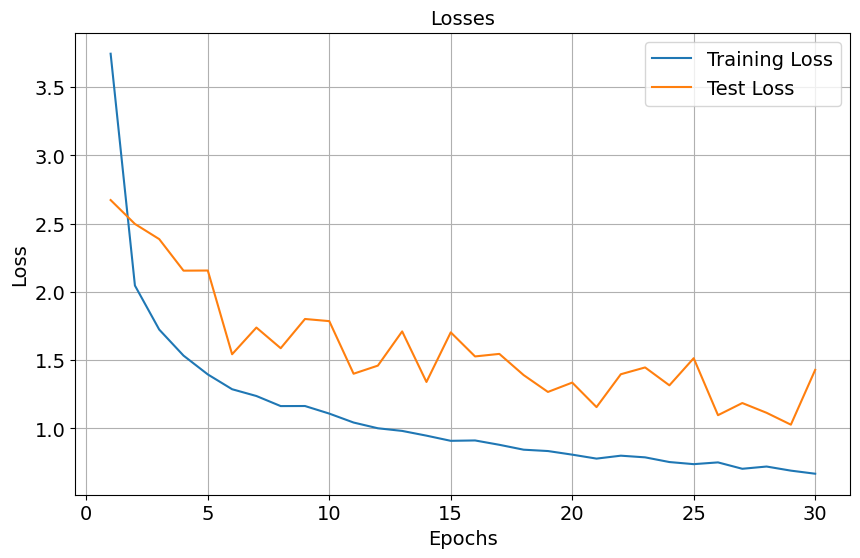

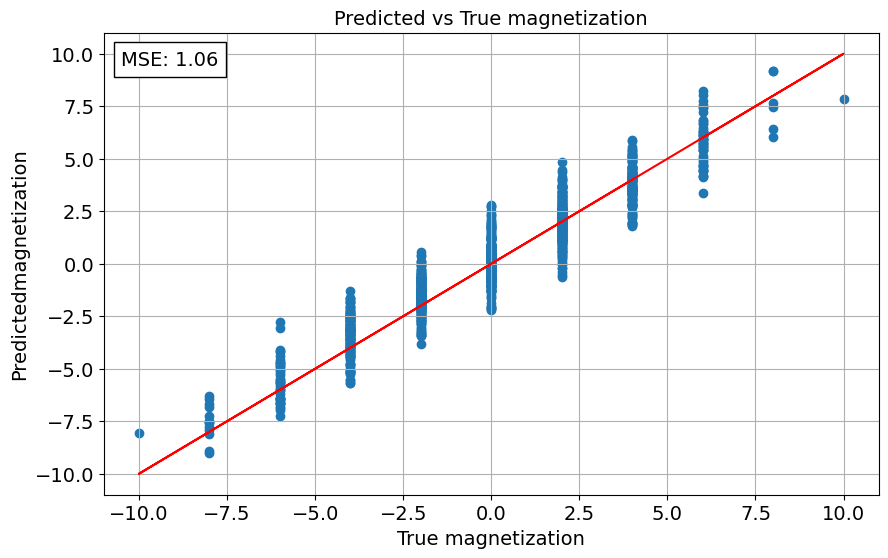

--------------------------------------------


n_dimensions: 2, periodic: True, number of connections: 20
Training ...
Ep 1 	| Loss 3.67261 	| Test Loss 2.19805
Ep 2 	| Loss 2.09544 	| Test Loss 1.80652
Ep 3 	| Loss 1.83103 	| Test Loss 1.86631
Ep 4 	| Loss 1.59373 	| Test Loss 1.54758
Ep 5 	| Loss 1.47471 	| Test Loss 1.64314
Ep 6 	| Loss 1.37244 	| Test Loss 1.68656
Ep 7 	| Loss 1.31123 	| Test Loss 1.62668
Ep 8 	| Loss 1.21385 	| Test Loss 1.67412
Ep 9 	| Loss 1.20835 	| Test Loss 1.43002
Ep 10 	| Loss 1.08933 	| Test Loss 1.28876
Ep 11 	| Loss 1.09351 	| Test Loss 1.33323
Ep 12 	| Loss 1.02253 	| Test Loss 1.32254
Ep 13 	| Loss 1.00341 	| Test Loss 1.39445
Ep 14 	| Loss 0.97082 	| Test Loss 1.18324
Ep 15 	| Loss 0.93711 	| Test Loss 1.25802
Ep 16 	| Loss 0.92229 	| Test Loss 1.36404
Ep 17 	| Loss 0.89868 	| Test Loss 1.44134
Ep 18 	| Loss 0.83881 	| Test Loss 1.14443
Ep 19 	| Loss 0.85056 	| Test Loss 1.29364
Ep 20 	| Loss 0.82093 	| Test Loss 1.11925
Ep 21 	| Loss 0.79878 	| Test 

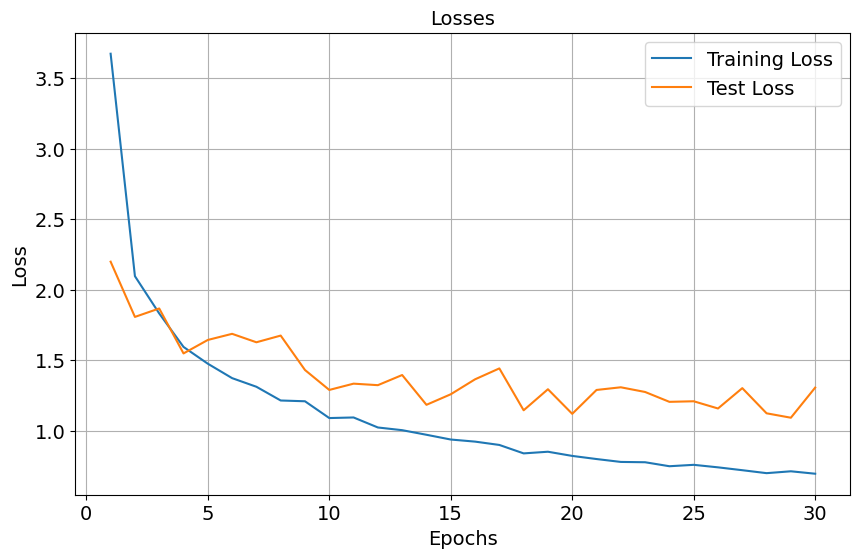

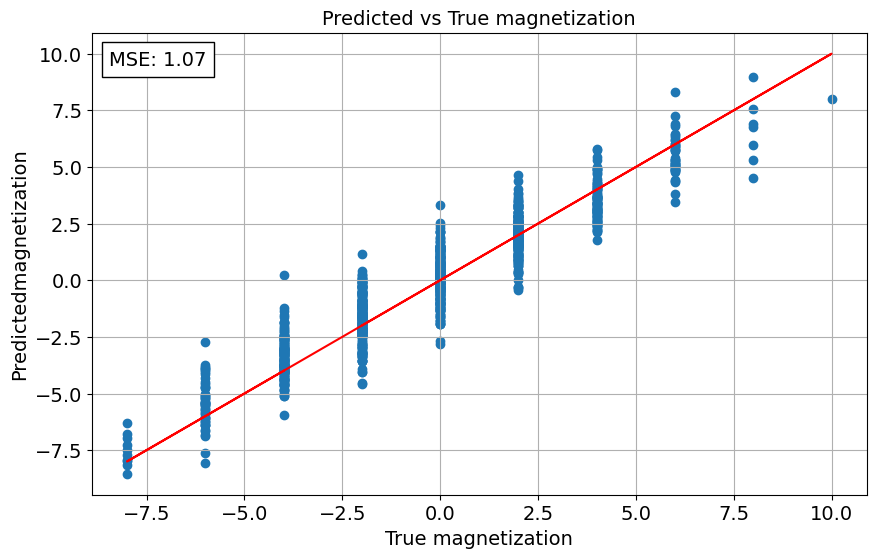

--------------------------------------------


n_dimensions: 3, periodic: False, number of connections: 24
Training ...
Ep 1 	| Loss 4.10422 	| Test Loss 2.92796
Ep 2 	| Loss 2.31339 	| Test Loss 2.16942
Ep 3 	| Loss 1.84519 	| Test Loss 2.40062
Ep 4 	| Loss 1.64992 	| Test Loss 2.51097
Ep 5 	| Loss 1.55662 	| Test Loss 2.6553
Ep 6 	| Loss 1.45555 	| Test Loss 1.7697
Ep 7 	| Loss 1.35523 	| Test Loss 1.70197
Ep 8 	| Loss 1.26223 	| Test Loss 1.84467
Ep 9 	| Loss 1.25594 	| Test Loss 1.43759
Ep 10 	| Loss 1.14791 	| Test Loss 1.59292
Ep 11 	| Loss 1.13542 	| Test Loss 1.70113
Ep 12 	| Loss 1.12117 	| Test Loss 1.61414
Ep 13 	| Loss 1.03963 	| Test Loss 1.75374
Ep 14 	| Loss 1.02612 	| Test Loss 2.29346
Ep 15 	| Loss 0.97951 	| Test Loss 1.29714
Ep 16 	| Loss 0.94603 	| Test Loss 1.43598
Ep 17 	| Loss 0.93505 	| Test Loss 1.91664
Ep 18 	| Loss 0.93292 	| Test Loss 1.31803
Ep 19 	| Loss 0.88793 	| Test Loss 1.40205
Ep 20 	| Loss 0.8888 	| Test Loss 1.53949
Ep 21 	| Loss 0.86229 	| Test Lo

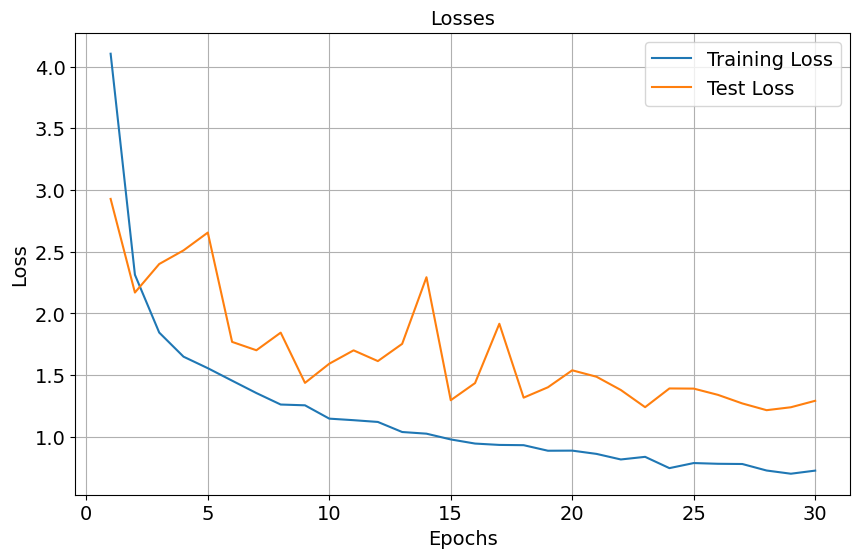

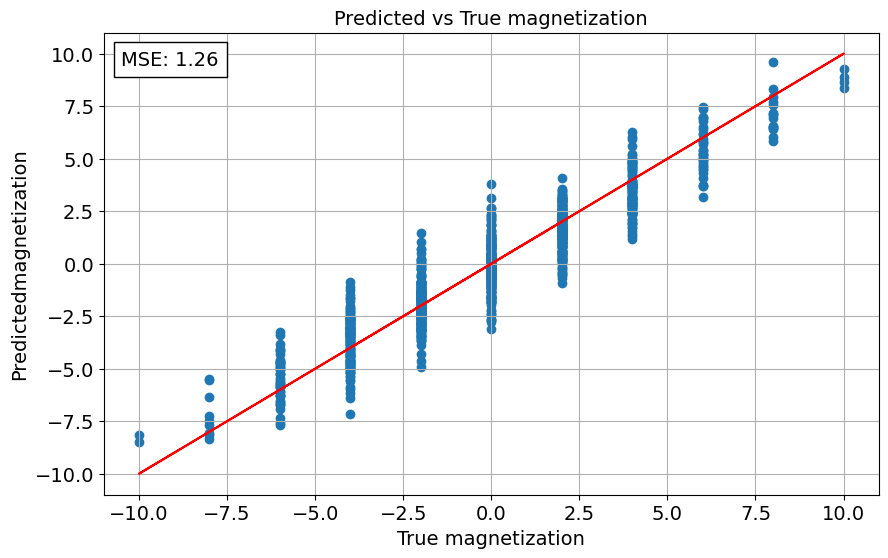

--------------------------------------------


n_dimensions: 3, periodic: True, number of connections: 30
Training ...
Ep 1 	| Loss 3.93719 	| Test Loss 2.42858
Ep 2 	| Loss 2.23807 	| Test Loss 2.00282
Ep 3 	| Loss 1.90279 	| Test Loss 1.82278
Ep 4 	| Loss 1.67508 	| Test Loss 1.83581
Ep 5 	| Loss 1.55399 	| Test Loss 1.74353
Ep 6 	| Loss 1.46967 	| Test Loss 1.60827
Ep 7 	| Loss 1.36683 	| Test Loss 1.53826
Ep 8 	| Loss 1.33264 	| Test Loss 1.43847
Ep 9 	| Loss 1.2272 	| Test Loss 1.54106
Ep 10 	| Loss 1.17764 	| Test Loss 1.6178
Ep 11 	| Loss 1.15574 	| Test Loss 1.33412
Ep 12 	| Loss 1.11605 	| Test Loss 1.52513
Ep 13 	| Loss 1.05838 	| Test Loss 1.45028
Ep 14 	| Loss 1.00976 	| Test Loss 1.46479
Ep 15 	| Loss 1.00929 	| Test Loss 1.31721
Ep 16 	| Loss 0.98127 	| Test Loss 1.39599
Ep 17 	| Loss 0.93439 	| Test Loss 1.56665
Ep 18 	| Loss 0.93468 	| Test Loss 1.30144
Ep 19 	| Loss 0.90301 	| Test Loss 1.42571
Ep 20 	| Loss 0.87686 	| Test Loss 1.37824
Ep 21 	| Loss 0.87397 	| Test Lo

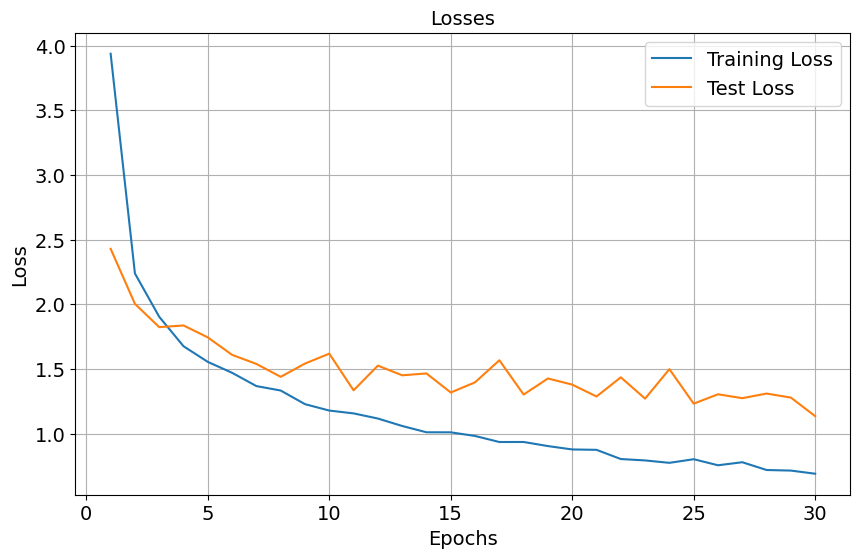

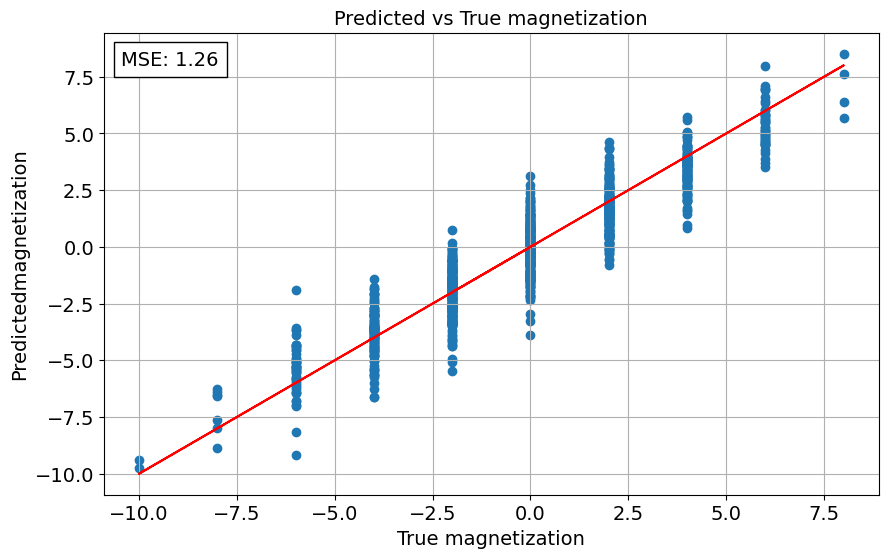

--------------------------------------------


n_dimensions: 4, periodic: False, number of connections: 30
Training ...
Ep 1 	| Loss 4.13367 	| Test Loss 2.84798
Ep 2 	| Loss 2.30399 	| Test Loss 1.92636
Ep 3 	| Loss 1.92041 	| Test Loss 1.68734
Ep 4 	| Loss 1.68671 	| Test Loss 1.57075
Ep 5 	| Loss 1.52293 	| Test Loss 1.5175
Ep 6 	| Loss 1.41994 	| Test Loss 1.43047
Ep 7 	| Loss 1.35194 	| Test Loss 1.39427
Ep 8 	| Loss 1.29276 	| Test Loss 1.49951
Ep 9 	| Loss 1.22868 	| Test Loss 1.31192
Ep 10 	| Loss 1.18389 	| Test Loss 1.24568
Ep 11 	| Loss 1.13808 	| Test Loss 1.41198
Ep 12 	| Loss 1.03574 	| Test Loss 1.42071
Ep 13 	| Loss 1.01747 	| Test Loss 1.5763
Ep 14 	| Loss 0.9747 	| Test Loss 1.38518
Ep 15 	| Loss 0.92395 	| Test Loss 1.21073
Ep 16 	| Loss 0.92035 	| Test Loss 1.25258
Ep 17 	| Loss 0.87001 	| Test Loss 1.29726
Ep 18 	| Loss 0.82126 	| Test Loss 1.23761
Ep 19 	| Loss 0.84801 	| Test Loss 1.25894
Ep 20 	| Loss 0.81597 	| Test Loss 1.30394
Ep 21 	| Loss 0.78808 	| Test Lo

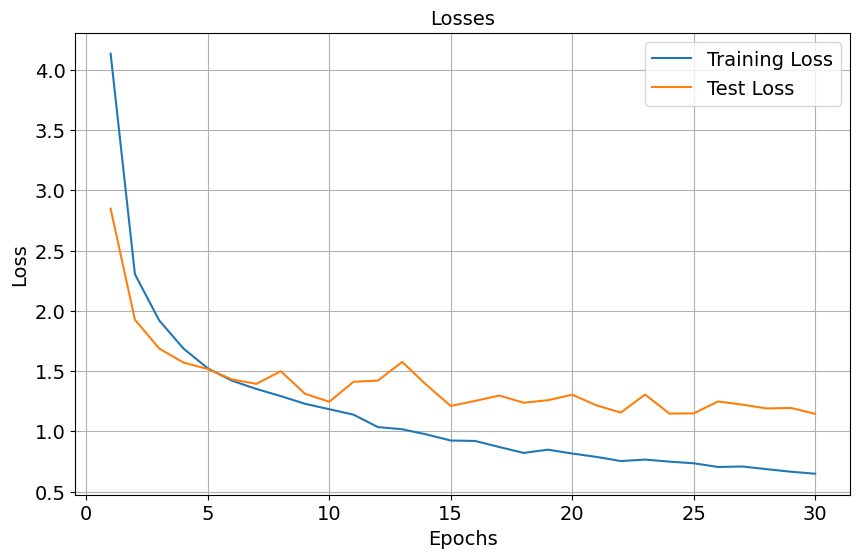

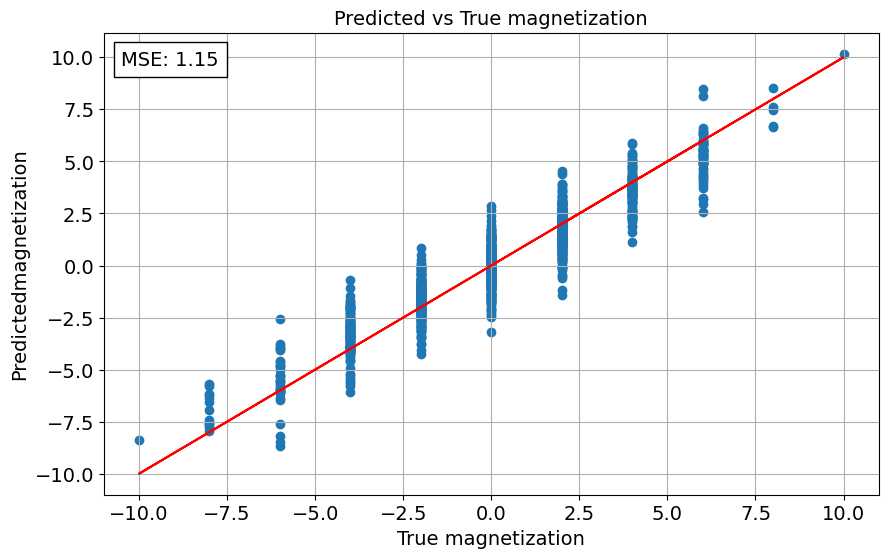

--------------------------------------------


n_dimensions: 4, periodic: True, number of connections: 40
Training ...
Ep 1 	| Loss 3.86274 	| Test Loss 2.27057
Ep 2 	| Loss 2.2368 	| Test Loss 1.91147
Ep 3 	| Loss 1.91418 	| Test Loss 1.83969
Ep 4 	| Loss 1.74768 	| Test Loss 1.8316
Ep 5 	| Loss 1.56346 	| Test Loss 1.73513
Ep 6 	| Loss 1.48494 	| Test Loss 1.62241
Ep 7 	| Loss 1.36547 	| Test Loss 1.4791
Ep 8 	| Loss 1.29366 	| Test Loss 1.76553
Ep 9 	| Loss 1.20789 	| Test Loss 1.60256
Ep 10 	| Loss 1.1729 	| Test Loss 1.87998
Ep 11 	| Loss 1.10322 	| Test Loss 1.36598
Ep 12 	| Loss 1.05153 	| Test Loss 1.51319
Ep 13 	| Loss 1.08695 	| Test Loss 1.59445
Ep 14 	| Loss 1.02695 	| Test Loss 1.47824
Ep 15 	| Loss 0.96637 	| Test Loss 1.3248
Ep 16 	| Loss 0.9784 	| Test Loss 1.34639
Ep 17 	| Loss 0.93338 	| Test Loss 1.54151
Ep 18 	| Loss 0.87638 	| Test Loss 1.3829
Ep 19 	| Loss 0.86375 	| Test Loss 1.3433
Ep 20 	| Loss 0.84506 	| Test Loss 1.34693
Ep 21 	| Loss 0.80074 	| Test Loss 1.3

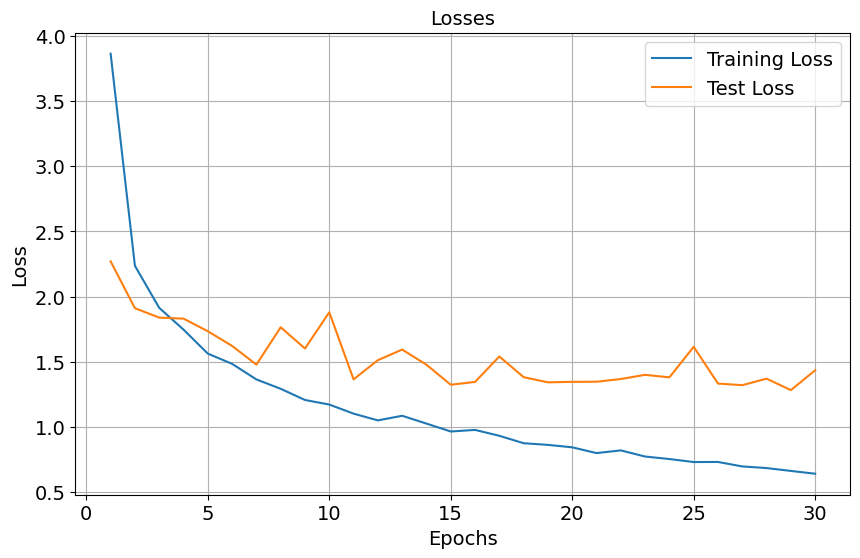

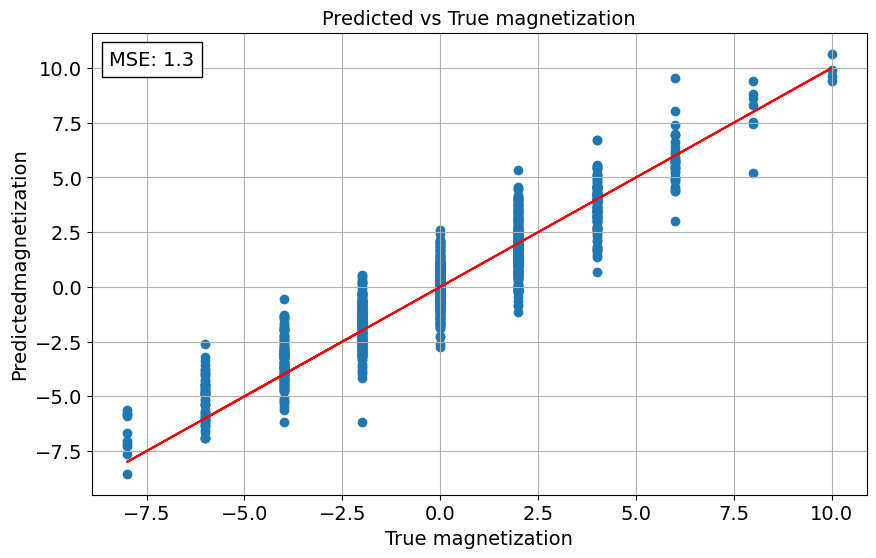

--------------------------------------------


n_dimensions: 5, periodic: False, number of connections: 35
Training ...
Ep 1 	| Loss 4.29115 	| Test Loss 3.69149
Ep 2 	| Loss 2.26665 	| Test Loss 2.67878
Ep 3 	| Loss 1.94424 	| Test Loss 2.39688
Ep 4 	| Loss 1.64457 	| Test Loss 2.1698
Ep 5 	| Loss 1.55168 	| Test Loss 2.27458
Ep 6 	| Loss 1.40706 	| Test Loss 2.59941
Ep 7 	| Loss 1.34296 	| Test Loss 1.74886
Ep 8 	| Loss 1.24932 	| Test Loss 1.68329
Ep 9 	| Loss 1.22029 	| Test Loss 1.89948
Ep 10 	| Loss 1.13016 	| Test Loss 1.57847
Ep 11 	| Loss 1.07794 	| Test Loss 1.82389
Ep 12 	| Loss 1.0401 	| Test Loss 1.53303
Ep 13 	| Loss 1.03592 	| Test Loss 1.52543
Ep 14 	| Loss 0.97101 	| Test Loss 1.54624
Ep 15 	| Loss 0.93927 	| Test Loss 1.359
Ep 16 	| Loss 0.94718 	| Test Loss 1.37039
Ep 17 	| Loss 0.89027 	| Test Loss 1.34367
Ep 18 	| Loss 0.87506 	| Test Loss 1.28244
Ep 19 	| Loss 0.86315 	| Test Loss 1.33861
Ep 20 	| Loss 0.81568 	| Test Loss 1.40285
Ep 21 	| Loss 0.81087 	| Test Los

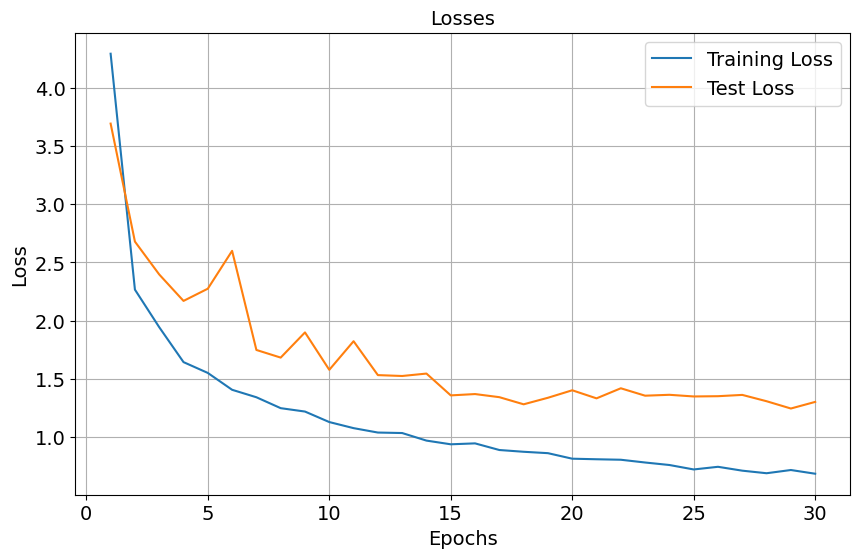

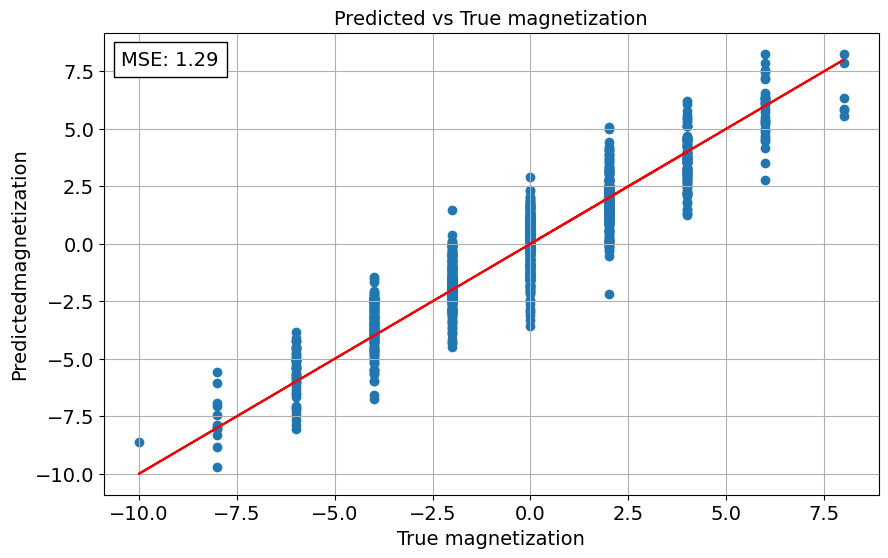

--------------------------------------------


n_dimensions: 5, periodic: True, number of connections: 45
Training ...
Ep 1 	| Loss 4.29801 	| Test Loss 2.99975
Ep 2 	| Loss 2.40553 	| Test Loss 2.19134
Ep 3 	| Loss 2.00312 	| Test Loss 2.15417
Ep 4 	| Loss 1.78801 	| Test Loss 1.83185
Ep 5 	| Loss 1.66666 	| Test Loss 1.58598
Ep 6 	| Loss 1.53559 	| Test Loss 1.77299
Ep 7 	| Loss 1.41565 	| Test Loss 1.58571
Ep 8 	| Loss 1.35129 	| Test Loss 1.63014
Ep 9 	| Loss 1.23176 	| Test Loss 1.63687
Ep 10 	| Loss 1.15898 	| Test Loss 1.59709
Ep 11 	| Loss 1.15406 	| Test Loss 1.66332
Ep 12 	| Loss 1.10101 	| Test Loss 1.39797
Ep 13 	| Loss 1.03016 	| Test Loss 1.38457
Ep 14 	| Loss 1.00303 	| Test Loss 1.45546
Ep 15 	| Loss 0.96404 	| Test Loss 1.507
Ep 16 	| Loss 0.90443 	| Test Loss 1.52886
Ep 17 	| Loss 0.90408 	| Test Loss 1.53771
Ep 18 	| Loss 0.82396 	| Test Loss 1.42989
Ep 19 	| Loss 0.83172 	| Test Loss 1.4063
Ep 20 	| Loss 0.81116 	| Test Loss 1.47668
Ep 21 	| Loss 0.7966 	| Test Loss

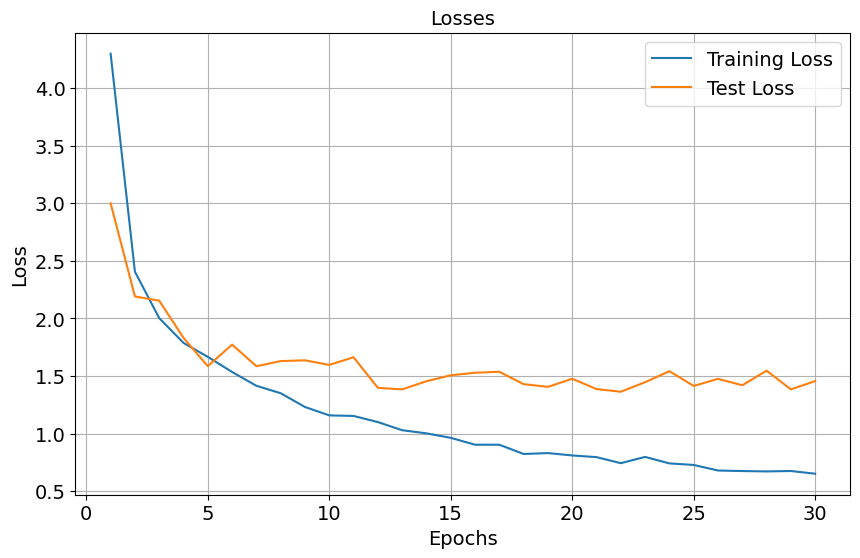

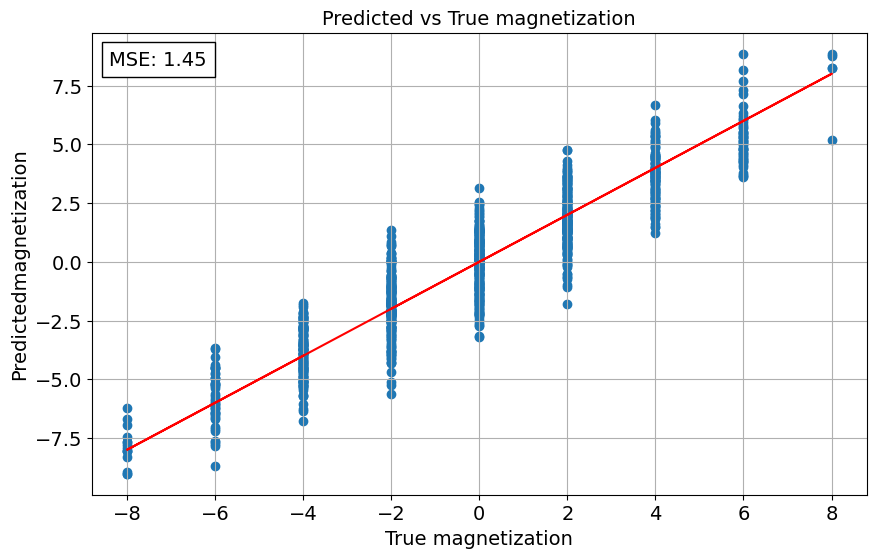

--------------------------------------------




In [28]:
i = 0 # index to keep track of the dataset

for n_dimensions in list_dimensions:
    for periodic in list_periodic:

        dataset = list_datasets[i]
        graphs = list_graphs[i]

        # get number of connections
        n_connections = len(graphs[0].edges)
        list_n_connections.append(n_connections)

        print(f"n_dimensions: {n_dimensions}, periodic: {periodic}, number of connections: {n_connections}")


        # split the dataset into training and test set and create the loaders
        train_loader = DataLoader(dataset[:int(0.8*n_samples)], batch_size=batch_size, shuffle=False) # shuffle not needed
        test_loader = DataLoader(dataset[int(0.8*n_samples):], batch_size=batch_size, shuffle=False)

        # copy the model from scratch
        model = GNN(hidden_channels_1=hidden_channels_1, hidden_channels_2=hidden_channels_2, hidden_channels_3=hidden_channels_3,
            hidden_channels_4=hidden_channels_4, hidden_linear=hidden_linear, lr=lr, weight_decay=weight_decay, dropout=dropout)

        model.to(device)

        # set the model name
        model_name = set_model_name(n_nodes, n_dimensions, h, periodic, n_samples, hidden_channels_1, hidden_channels_2, hidden_channels_3, hidden_channels_4, hidden_linear, lr, weight_decay, dropout,num_epochs) + "_magnetization"
        list_model_names.append(model_name)

        try:
            os.mkdir(model_name )
        except:
            pass

        # save the graph plot 
        fig.savefig(model_name + "/graph.png")

        # train the model
        train_losses, test_losses = train_model(model, train_loader, test_loader, num_epochs, patience=patience, model_name=model_name, verbose=True, device=device)
        list_train_losses.append(train_losses)
        list_test_losses.append(test_losses)

        # save train and test losses 
        np.save(model_name + '/train_losses.npy', train_losses)
        np.save(model_name + '/test_losses.npy', test_losses)
          

        # plot the losses
        fig_losses = plot_loss(train_losses, test_losses)
        fig_losses.savefig(model_name + "/losses.png")
        list_fig_losses.append(fig_losses)

        # test the trained model
        fig, mse = test_trained_model(model_name, test_loader, device=device,ax_name="magnetization")
        fig.savefig(model_name + "/test.png")
        list_fig_tests.append(fig)

        # store the mse
        list_mse.append(mse)

        print(44 * '-')
        print("\n")

        folder_name = f"n_nodes_{n_nodes}_n_dimensions_{n_dimensions}"
        try: os.mkdir(folder_name)
        except: pass

        # move the files to the folder
        os.system(f"mv {model_name} {folder_name}/{model_name}")     

        i += 1 # update the index for the dataset
                     

        

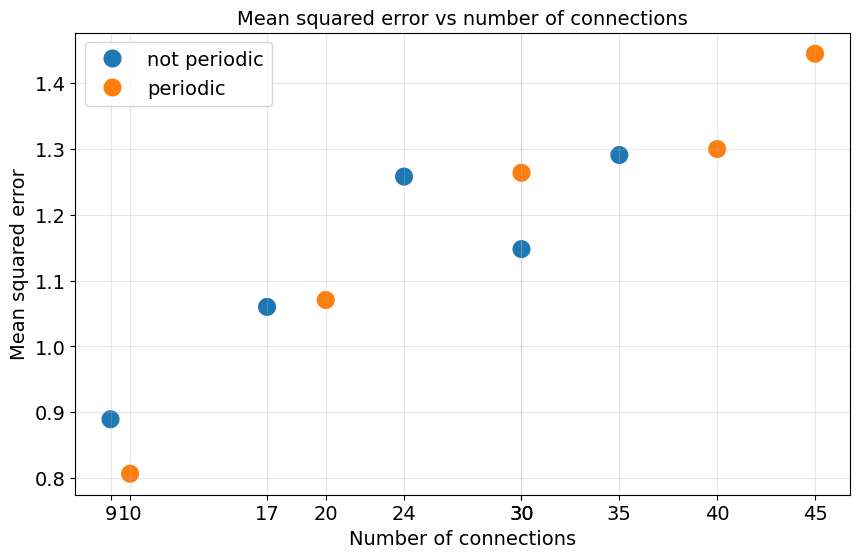

In [29]:
# plot the mse vs the number of connections
fig = plt.figure()
# set a label for even positions on list_n_connections
labels = ["not periodic" if i%2 == 0 else "periodic" for i in np.arange(len(list_n_connections))]


sns.scatterplot(x = list_n_connections, y= list_mse, hue=labels, size=labels, sizes=(200, 200) )

plt.xlabel('Number of connections')
plt.ylabel('Mean squared error')
plt.title('Mean squared error vs number of connections')
plt.xticks(list_n_connections)
plt.grid(alpha=0.3)


plt.show(fig)
fig.savefig(f"mse_vs_connections_{n_samples}_magnetization.png")
